<a href="https://colab.research.google.com/github/williamtheodoruswijaya/Datathon-UI-2025/blob/main/notebook/William/William_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Objective

Prediksi apakah suatu perusahaan yang mengajukan IPO dapat sukses dan meraih keuntungan atau tidak?

- Faktor pengukuran kesuksesan biasanya dilihat dari banyaknya orang yang mau beli sahamnya atau tidak.

In [938]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [939]:
df = pd.read_csv("./mod_data.csv")

df.head()

Ticker                  Nama Perusahaan Tanggal Listing  \
0   UNIQ               PT Ulima Nitra Tbk        8-Mar-21   
1   GTRA  PT Grahaprima Suksesmandiri Tbk       30-Mar-23   
2   BSBK  PT Wulandari Bangun Laksana Tbk        8-Nov-22   
3   COAL   PT Black Diamond Resources Tbk        7-Sep-22   
4   CRAB    PT Toba Surimi Industries Tbk       10-Aug-22   

                      Sektor  \
0                     Energy   
1  Transportation & Logistic   
2   Properties & Real Estate   
3                     Energy   
4     Consumer Non-Cyclicals   

                                         Underwriter   Papan Pencatatan  \
0                           PT Surya Fajar Sekuritas              utama   
1                          PT UOB Kay Hian Sekuritas       pengembangan   
2  PT KGI Sekuritas Indonesia; PT Panca Global Se...       pengembangan   
3                           PT Surya Fajar Sekuritas  pemantauan khusus   
4                         PT KGI Sekuritas Indonesia       pengembangan   

  Ownership  Listed Share  Persen Saham Ditawarkan  \
0   lainnya  3.138983e+09                   0.0956   
1   lainnya  1.894375e+09                   0.2000   
2   lainnya  2.275000e+10                   0.1209   
3   lainnya  6.250000e+09                   0.2000   
4   lainnya  1.950000e+09                   0.2000   

  Rencana Penggunaan Dana IPO  ... Total Liabilitas    Pendapatan  \
0                 modal kerja  ...     2.670000e+11  2.710000e+11   
1               modal belanja  ...     4.570000e+11  1.950000e+11   
2                 modal kerja  ...     1.120000e+12  5.590600e+10   
3                 modal kerja  ...     2.500000e+14  9.553076e+10   
4                 modal kerja  ...     2.470000e+11  1.360000e+11   

     Laba Kotor  Laba Berjalan (Bukan Komperhensif)  Harga Final  1D %  1W %  \
0  2.454700e+10                       -5.617000e+09          118   999    35   
1  8.756900e+10                        1.130000e+11          150   999    85   
2  3.895000e+10                       -1.943000e+09          100   999   170   
3  4.902891e+10                        4.330173e+10          100   999   280   
4  1.738746e+10                        2.926422e+09          150   999    56   

    1M %  6M %  1Y %  
0    5.0 -25.0 -30.0  
1   77.0  39.0   9.0  
2  140.0 -50.0 -50.0  
3  354.0  36.0 -45.0  
4   59.0  41.0  59.0  

[5 rows x 22 columns]

In [940]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Ticker                              223 non-null    object 
 1   Nama Perusahaan                     223 non-null    object 
 2   Tanggal Listing                     223 non-null    object 
 3   Sektor                              223 non-null    object 
 4   Underwriter                         223 non-null    object 
 5   Papan Pencatatan                    223 non-null    object 
 6   Ownership                           223 non-null    object 
 7   Listed Share                        223 non-null    float64
 8   Persen Saham Ditawarkan             223 non-null    float64
 9   Rencana Penggunaan Dana IPO         223 non-null    object 
 10  Valuation Currency                  223 non-null    object 
 11  Total Aset                          223 non-n

### Small Explanations:

This's a classification problem to classify this target columns:

- **Harga Final**: Harga final penawaran saham yang ditetapkan
- **1D %**: Persentase keuntungan / kerugian harga saham pada hari pertama perdagangan. (Ngukur initial pop sebuah IPO)
    - Multiclass Classification:
        'ARA': kinerja luar biasa, harga menyentuh batas kenaikan harian.
        'Naik': kinerja positif, tidak mencapai ARA
        'Turun': kinerja negatif
- **1W %**
- **1M %**
- **6M %**
- **1Y %**

Sisanya literally persentase keuntungan dan kerugian saham berdasarkan periode waktu.

## Exploratory Data Analysis & Preprocessing

### 1. Ubah beberapa kolom ke dalam float

In [941]:
cols_to_float = ['Listed Share', 'Total Aset', 'Total Liabilitas', 'Pendapatan', 'Harga Final']
df[cols_to_float] = df[cols_to_float].astype(float)

### 2. Menghilangkan persentase ("%")

In [942]:
cols_percent = ['1D %', '1W %', '1M %', '6M %', '1Y %']
df[cols_percent] = df[cols_percent].replace('%', '', regex=True).astype(float)

### 3. Missing Value

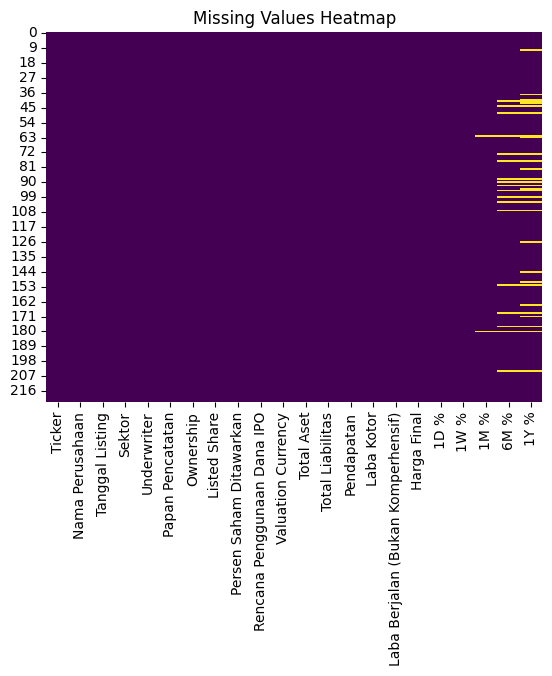

In [943]:
sns.heatmap(df.isna(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

## Feature Engineering

### Creating a Classification Problem

1. Mengubah kolom 1D % dari numerik menjadi kategorikal berdasarkan ARA.

Jika 1D % == 999 -> maka kita ubah jadi ARA, sedangkan kalau 1D % > 0 -> maka kita ubah jadi plus, dan kalau 1D % < 0, kita ubah jadi minus.

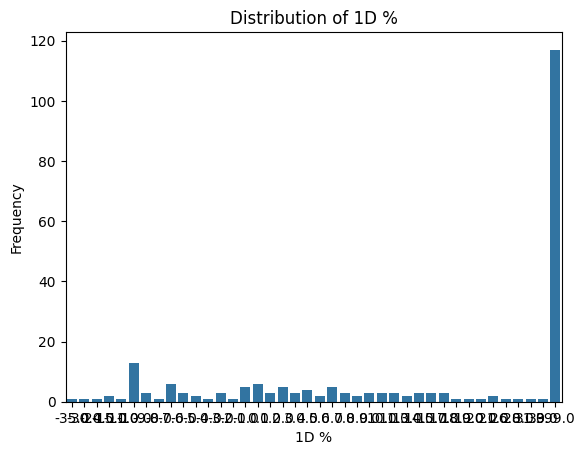

In [944]:
sns.countplot(x="1D %", data=df)
plt.title('Distribution of 1D %')
plt.xlabel('1D %')
plt.ylabel('Frequency')
plt.show()

Sekarang kalau kita ubah:

In [945]:
df['1D %'] = df['1D %'].apply(lambda x: 'ARA' if x == 999 else ('plus' if x >= 0 else 'minus'))

Maka, akan menjadi kolom kategorikal dengan distribusi sebagai berikut:

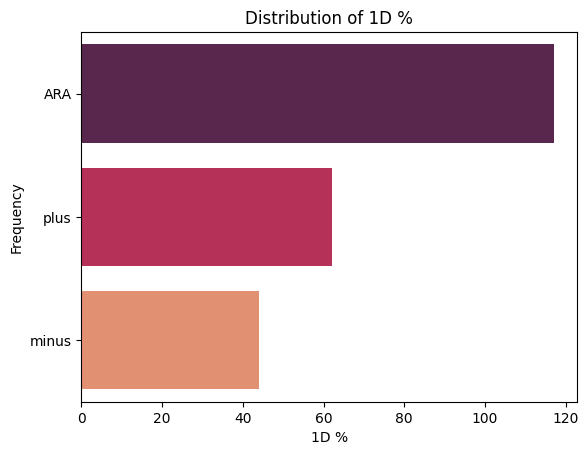

In [946]:
sns.countplot(df['1D %'], palette="rocket")
plt.title('Distribution of 1D %')
plt.xlabel('1D %')
plt.ylabel('Frequency')
plt.show()

Untuk kolom target seperti 1W %, 1M %, 6M %, dan 1Y% masih merupakan kolom numerik. Jadi, kita dapat cek distribusi-nya terlebih dahulu.

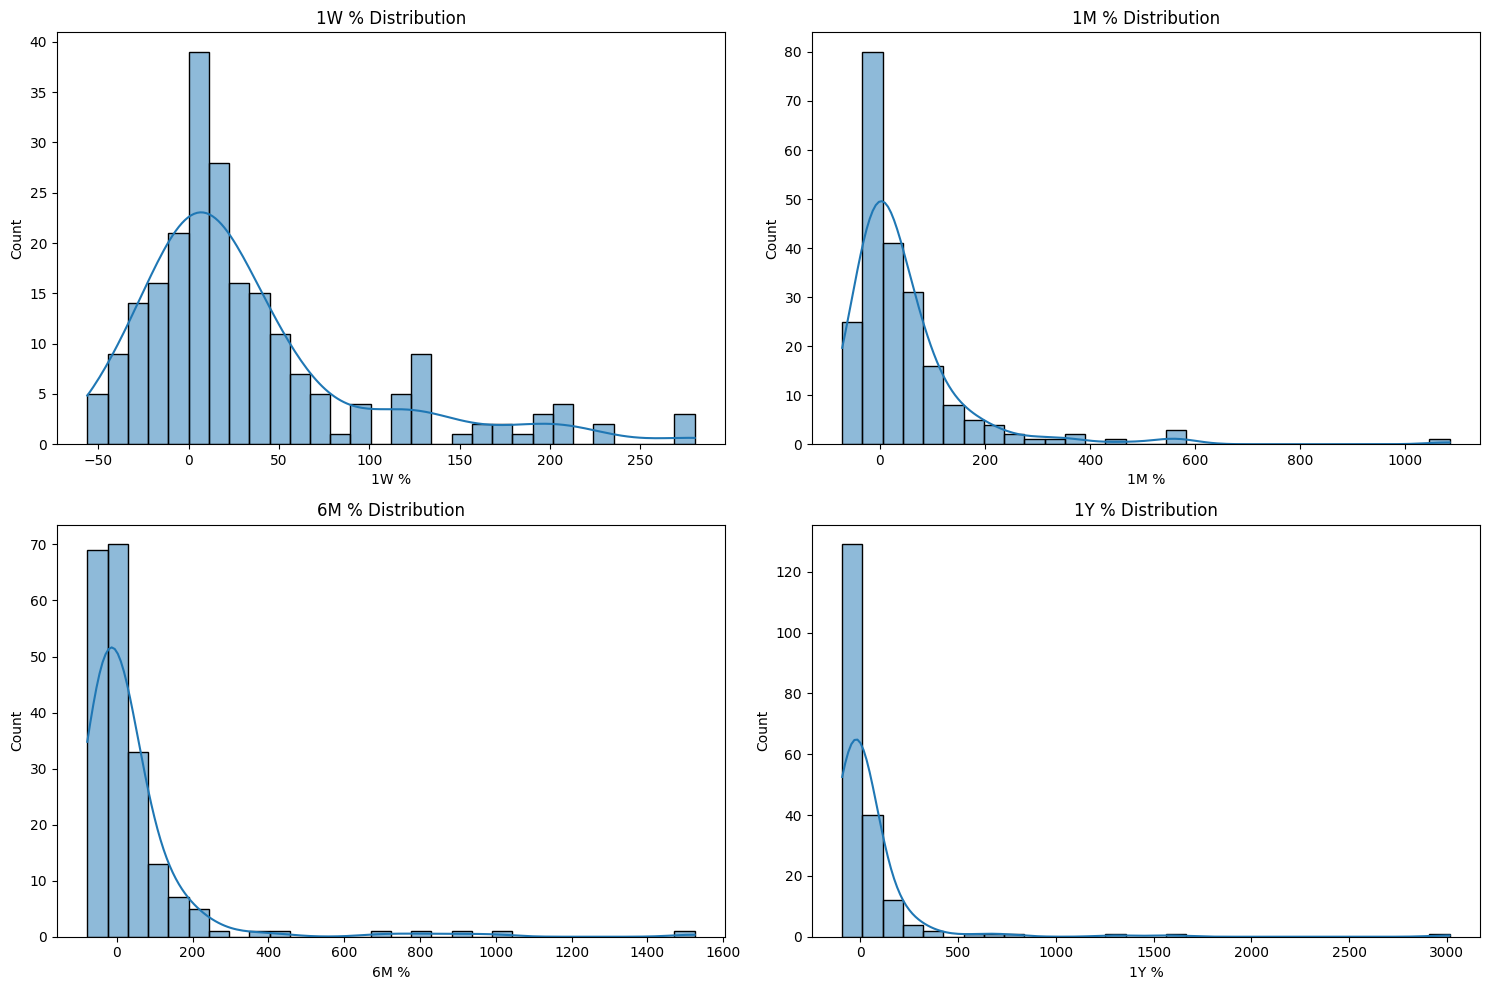

In [947]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df['1W %'].dropna(), bins=30, ax=ax[0, 0], kde=True)
sns.histplot(df['1M %'].dropna(), bins=30, ax=ax[0, 1], kde=True)
sns.histplot(df['6M %'].dropna(), bins=30, ax=ax[1, 0], kde=True)
sns.histplot(df['1Y %'].dropna(), bins=30, ax=ax[1, 1], kde=True)
ax[0, 0].set_title('1W % Distribution')
ax[0, 1].set_title('1M % Distribution')
ax[1, 0].set_title('6M % Distribution')
ax[1, 1].set_title('1Y % Distribution')
plt.tight_layout()
plt.show()

Ubah kolom 1W % dan kolom 1M % menjadi 2 kategori yaitu good dan bad

In [948]:
def categorize_mid(val):
    if pd.isnull(val):
        return val
    return 'good' if val >= 5 else 'bad'

for col in ['1W %', '1M %']:
    df[col] = df[col].apply(categorize_mid)

Ubah kolom 6M % dan kolom 1Y % menjadi 2 kategori yaitu plus dan minus

In [949]:
def categorize_long(val):
    if pd.isnull(val):
        return val
    elif val >= 0:
        return 'plus'
    else:
        return 'minus'

for col in ['6M %', '1Y %']:
    df[col] = df[col].apply(categorize_long)

#### Conclusions

Jadi, kita punya sekarang punya target label berupa kategorikal columns.

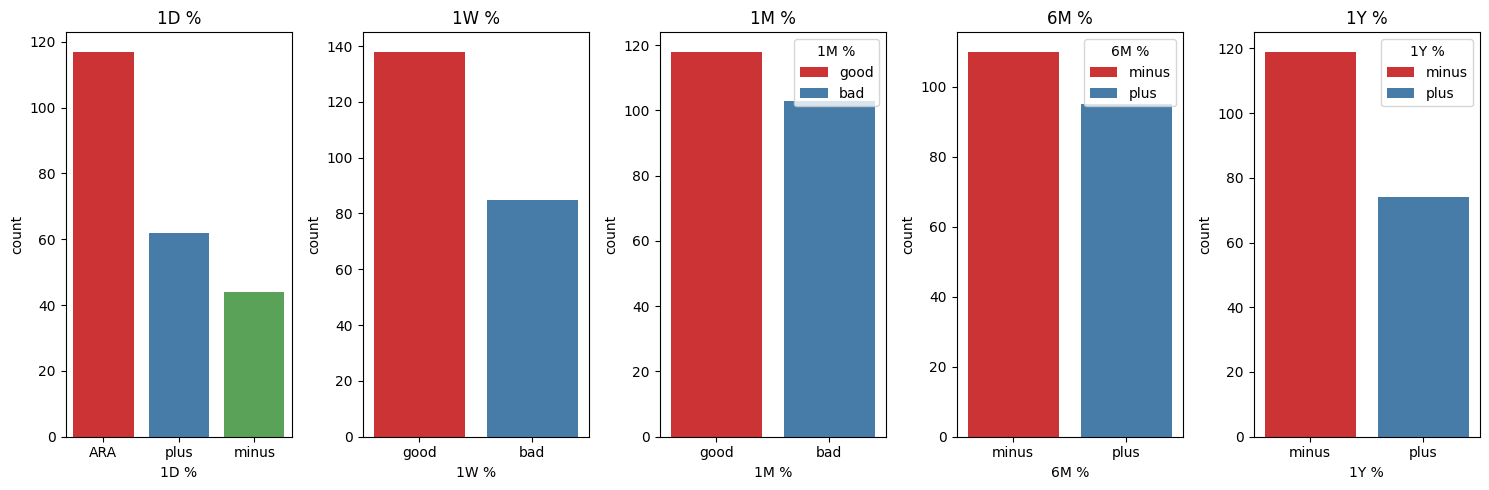

In [950]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
sns.countplot(x='1D %', data=df, ax=ax[0], hue='1D %', palette='Set1')
sns.countplot(x='1W %', data=df, ax=ax[1], hue='1W %', palette='Set1')
sns.countplot(x='1M %', data=df, ax=ax[2], hue='1M %', palette='Set1')
sns.countplot(x='6M %', data=df, ax=ax[3], hue='6M %', palette='Set1')
sns.countplot(x='1Y %', data=df, ax=ax[4], hue='1Y %', palette='Set1')
ax[0].set_title('1D %')
ax[1].set_title('1W %')
ax[2].set_title('1M %')
ax[3].set_title('6M %')
ax[4].set_title('1Y %')
plt.tight_layout()
plt.show()

### 1. Datetime

In [951]:
df['Tanggal Listing'] = pd.to_datetime(df['Tanggal Listing'], format='%d-%b-%y', errors='coerce')
df.sort_values('Tanggal Listing', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

Ticker                Nama Perusahaan Tanggal Listing           Sektor  \
0   UNIQ             PT Ulima Nitra Tbk      2021-03-08           Energy   
1   ARCI         PT Archi Indonesia Tbk      2021-06-28  Basic Materials   
2   MASB  PT Bank Multiarta Sentosa Tbk      2021-06-30       Financials   
3   BMHS              PT Bundamedik Tbk      2021-07-06       Healthcare   
4   UVCR  PT Trimegah Karya Pratama Tbk      2021-07-27       Technology   

                                         Underwriter   Papan Pencatatan  \
0                           PT Surya Fajar Sekuritas              utama   
1  PT BNI Sekuritas; PT Mandiri Sekuritas; PT Cit...       pengembangan   
2                                   PT BCA Sekuritas  pemantauan khusus   
3                        PT Ciptadana Sekuritas Asia              utama   
4  PT Surya Fajar Sekuritas; PT Mirae Asset Sekur...       pengembangan   

     Ownership  Listed Share  Persen Saham Ditawarkan  \
0      lainnya  3.138983e+09                   0.0956   
1  konglomerat  2.483500e+10                   0.1500   
2      lainnya  1.226903e+09                   0.1500   
3  konglomerat  8.603416e+09                   0.0726   
4      lainnya  2.000000e+09                   0.2500   

  Rencana Penggunaan Dana IPO  ... Total Liabilitas    Pendapatan  \
0                 modal kerja  ...     2.670000e+11  2.710000e+11   
1                bayar hutang  ...     6.860000e+12  4.960000e+12   
2                 modal kerja  ...     1.960000e+13  1.210000e+12   
3                bayar hutang  ...     1.110000e+12  1.150000e+12   
4               modal belanja  ...     1.435880e+10  1.940000e+11   

     Laba Kotor  Laba Berjalan (Bukan Komperhensif)  Harga Final  1D %  1W %  \
0  2.454700e+10                       -5.617000e+09        118.0   ARA  good   
1  2.710000e+12                        1.490000e+12        750.0  plus   bad   
2  4.310000e+11                        1.080000e+11       3360.0   ARA   bad   
3  3.680000e+11                        1.180000e+11        340.0   ARA  good   
4  4.634337e+09                        5.434916e+08        100.0   ARA  good   

   1M %   6M %   1Y %  
0  good  minus  minus  
1   bad  minus  minus  
2   bad   plus   plus  
3  good   plus   plus  
4  good   plus   plus  

[5 rows x 22 columns]

### 2. Underwriter

Ini part/fitur paling penting yang jadi patokan orang-orang dalam menentukan apakah dia akan beli saham atau engga.

Insight yang didapat:
- Underwriter mampu membawa harga saham naik.
- Underwriter yang secara historikal dia ampir selalu ngebawa harga sahamnya naik (contohnya ciptadana, trimegah, henan) -> **Ini yang wajib kita catat**
- Underwriter berupa bank gede (biasanya saham yang di bawa dia cenderung sideways (ga naik, ga turun)) (contohnya bca, bri, bni)
- Semakin sering underwriter menjadi bagian yang mempengaruhi saham, semakin tinggi orang-orang pada mau beli tu saham.


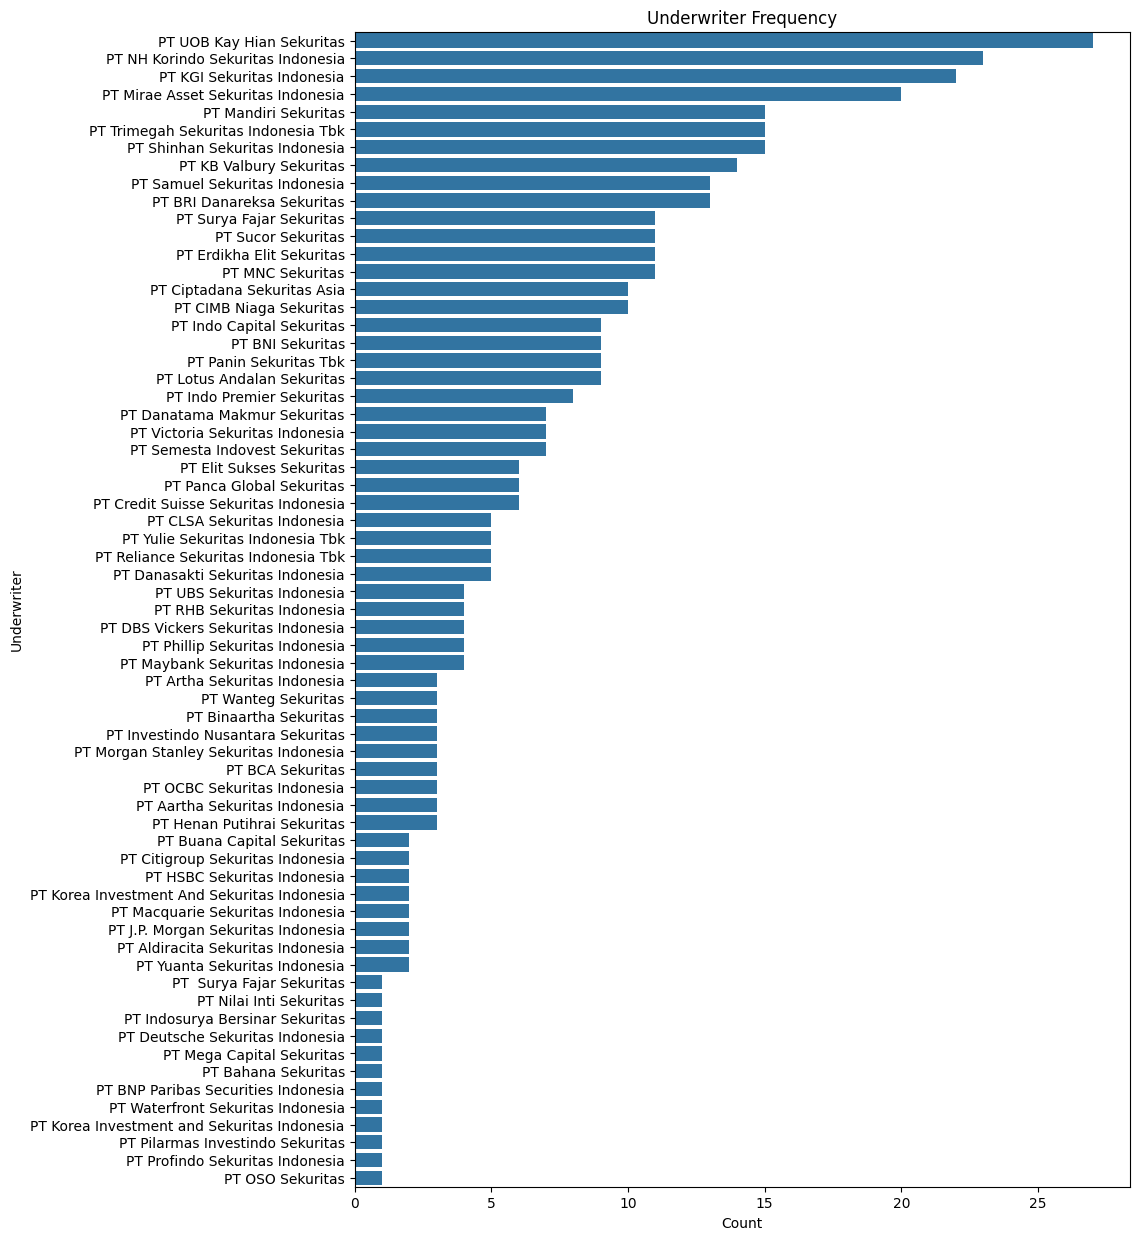

In [952]:
underwriters_exploded = df['Underwriter'].str.split(';').explode().str.strip()
plt.figure(figsize=(10, 15))
sns.countplot(y=underwriters_exploded, order=underwriters_exploded.value_counts().index)
plt.ylabel('Underwriter')
plt.xlabel('Count')
plt.title('Underwriter Frequency')
plt.show()

Sekarang, kita bisa melihat:
1. Underwriter mana yang:
    - paling aktif `freq`
    - cenderung menangani perusahaan besar `avg_aset`
    - mengelola penawaran saham bernilai tinggi `avg_jumlah`
2. Spesialisasi underwriter (apakah ada underwriter yang spesialis di sektor perusahaan dengan aset besar atau kecil?)

Ini juga bakal jadi pertimbangan buat perusahaan buat milih underwriter yang tepat buat perusahaan dia.

In [953]:
freq_dict = {}
aset_dict = {}
jumlah_dict = {}

for idx, row in df.iterrows():
    underwriters = [uw.strip() for uw in row['Underwriter'].split(';') if uw.strip()]
    persen = row['Persen Saham Ditawarkan']
    listed_share = row['Listed Share']
    harga_final = row['Harga Final']
    total_aset = row['Total Aset']

    jumlah = listed_share * harga_final * persen
    for uw in underwriters:
        freq_dict[uw] = freq_dict.get(uw, 0) + 1
        aset_dict[uw] = aset_dict.get(uw, 0.0) + total_aset
        jumlah_dict[uw] = jumlah_dict.get(uw, 0.0) + jumlah

uw_stats = []
for uw in freq_dict:
    freq = freq_dict[uw]
    avg_aset = aset_dict[uw] / freq if freq else 0
    avg_jumlah = jumlah_dict[uw] / freq if freq else 0
    uw_stats.append((uw, freq, avg_aset, avg_jumlah))

uw_df = pd.DataFrame(uw_stats, columns=['underwriter', 'freq', 'avg_aset', 'avg_jumlah']).reset_index(drop=True)
uw_df.head()

underwriter  freq      avg_aset    avg_jumlah
0              PT Surya Fajar Sekuritas    11  1.894937e+11  1.059479e+11
1                      PT BNI Sekuritas     9  3.898356e+13  4.461379e+12
2                  PT Mandiri Sekuritas    15  2.824633e+13  6.182559e+12
3      PT Citigroup Sekuritas Indonesia     2  2.134000e+13  6.393589e+12
4  PT Credit Suisse Sekuritas Indonesia     6  4.180333e+13  8.209206e+12

In [954]:
high_aset = uw_df['avg_aset'].quantile(0.75)
low_aset = uw_df['avg_aset'].quantile(0.25)

def aset_category(val):
    if val >= high_aset:
        return 'high'
    elif val <= low_aset:
        return 'low'
    else:
        return 'mid'

uw_df['avg_aset_category'] = uw_df['avg_aset'].apply(aset_category)

high_freq = uw_df['freq'].quantile(0.75)
low_freq = uw_df['freq'].quantile(0.25)

def freq_category(val):
    if val >= high_freq:
        return 'high'
    elif val <= low_freq:
        return 'low'
    else:
        return 'mid'

uw_df['freq_category'] = uw_df['freq'].apply(freq_category)
uw_df.head()

underwriter  freq      avg_aset    avg_jumlah  \
0              PT Surya Fajar Sekuritas    11  1.894937e+11  1.059479e+11   
1                      PT BNI Sekuritas     9  3.898356e+13  4.461379e+12   
2                  PT Mandiri Sekuritas    15  2.824633e+13  6.182559e+12   
3      PT Citigroup Sekuritas Indonesia     2  2.134000e+13  6.393589e+12   
4  PT Credit Suisse Sekuritas Indonesia     6  4.180333e+13  8.209206e+12   

  avg_aset_category freq_category  
0               low          high  
1              high          high  
2              high          high  
3              high           low  
4              high           mid

Sekarang, kita akan mengelompokkan para underwriter berdasarkan dua metrik yang sudah dihitung sebelumnya:
- rata-rata aset
- frekuensi

Pengelompokkan akan dilakukan menggunakan metode kuantil untuk membagi underwriter ke 3 grup yaitu `high`, `mid`, dan `low`

In [955]:
high_aset = uw_df['avg_aset'].quantile(0.75)
low_aset = uw_df['avg_aset'].quantile(0.25)

In [956]:
def aset_category(val):
    if val >= high_aset:
        return 'high'
    elif val <= low_aset:
        return 'low'
    else:
        return 'mid'

uw_df['avg_aset_category'] = uw_df['avg_aset'].apply(aset_category)

In [957]:
high_freq = uw_df['freq'].quantile(0.75)
low_freq = uw_df['freq'].quantile(0.25)

In [958]:
def freq_category(val):
    if val >= high_freq:
        return 'high'
    elif val <= low_freq:
        return 'low'
    else:
        return 'mid'

uw_df['freq_category'] = uw_df['freq'].apply(freq_category)

Final check:

In [959]:
uw_df.head()

underwriter  freq      avg_aset    avg_jumlah  \
0              PT Surya Fajar Sekuritas    11  1.894937e+11  1.059479e+11   
1                      PT BNI Sekuritas     9  3.898356e+13  4.461379e+12   
2                  PT Mandiri Sekuritas    15  2.824633e+13  6.182559e+12   
3      PT Citigroup Sekuritas Indonesia     2  2.134000e+13  6.393589e+12   
4  PT Credit Suisse Sekuritas Indonesia     6  4.180333e+13  8.209206e+12   

  avg_aset_category freq_category  
0               low          high  
1              high          high  
2              high          high  
3              high           low  
4              high           mid

Oke, sekarang kita tinggal implementasiin aja ke dataset asli kita.

1. Buat kolom baru `lead_underwriter`

In [960]:
df['lead_underwriter'] = df['Underwriter'].str.split(';').str[0].str.strip()

2. Buat dictionary berdasarkan `freq` dan `avg` tadi buat di mapping.

In [961]:
uw_map_freq_cat = uw_df.set_index('underwriter')['freq_category'].to_dict()
uw_map_aset_cat = uw_df.set_index('underwriter')['avg_aset_category'].to_dict()

3. Buat kategorikal kolom baru (2 buah) dengan mapping dictionary yang tadi.

- Disini, yang diambil adalah max value dari setiap underwriter suatu IPO

In [962]:
cat_order = {'low': 0, 'mid': 1, 'high': 2}
uw_map_freq_cat = uw_df.set_index('underwriter')['freq_category'].to_dict()
uw_map_aset_cat = uw_df.set_index('underwriter')['avg_aset_category'].to_dict()

def max_category(uw_str, uw_map):
    uws = [u.strip() for u in uw_str.split(';') if u.strip()]
    cats = [uw_map.get(u) for u in uws if uw_map.get(u) is not None]
    if not cats:
        return np.nan
    return max(cats, key=lambda x: cat_order[x])

df['underwriter_freq_category'] = df['Underwriter'].apply(lambda x: max_category(x, uw_map_freq_cat))
df['underwriter_avg_aset_category'] = df['Underwriter'].apply(lambda x: max_category(x, uw_map_aset_cat))

Sekarang, kita akan cek performa saham dengan kategori underwriter yang udah kita buat.

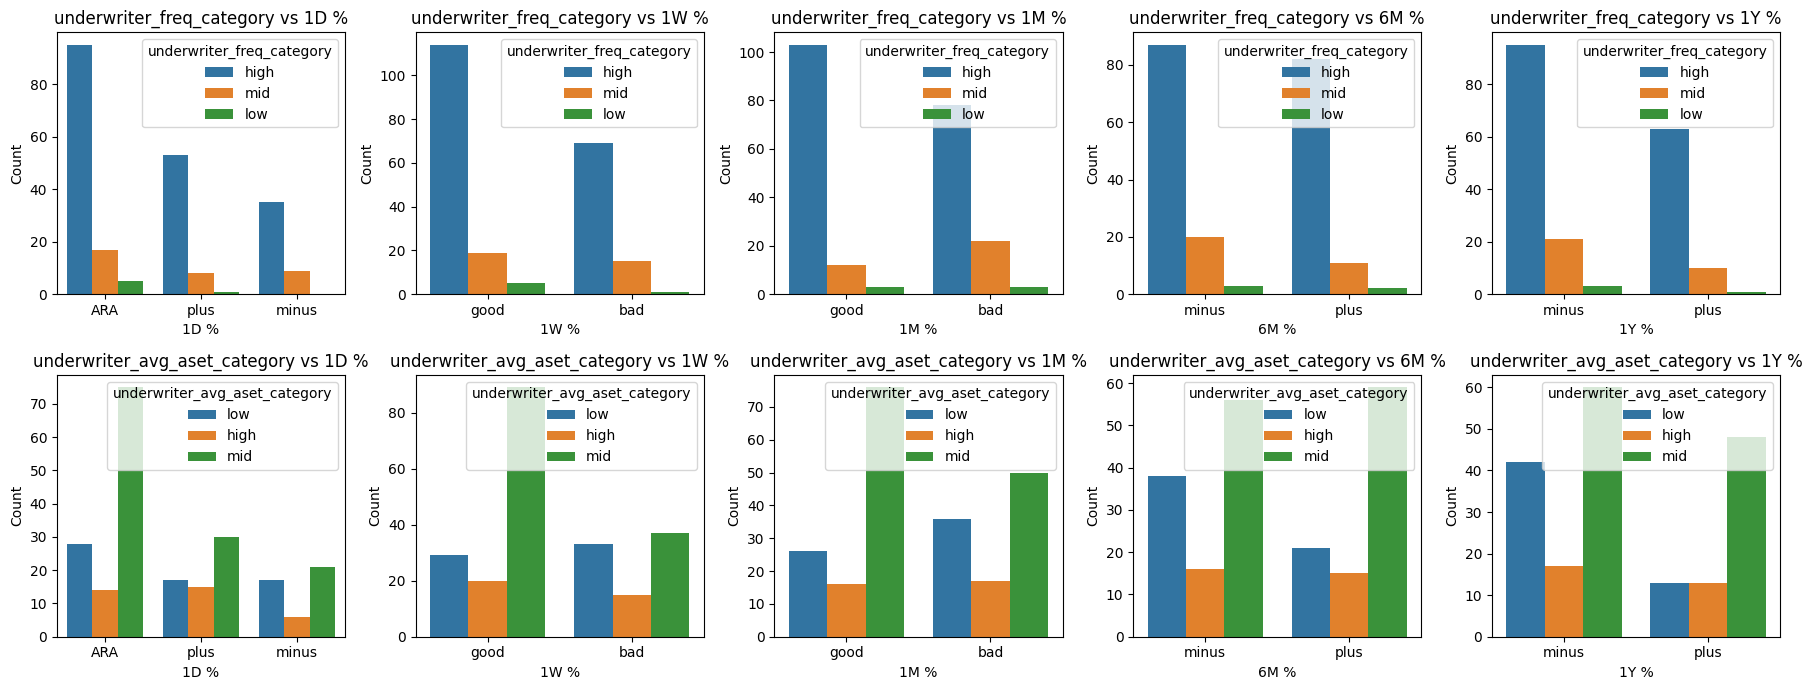

In [963]:
fig, axes = plt.subplots(2, 5, figsize=(18, 7))
target_cols = ['1D %', '1W %', '1M %', '6M %', '1Y %']
plot_cols = ['underwriter_freq_category', 'underwriter_avg_aset_category']

for i, col in enumerate(plot_cols):
    for j, target in enumerate(target_cols):
        ax = axes[i, j]
        sns.countplot(x=df[target], hue=df[col], ax=ax)
        ax.set_title(f"{col} vs {target}")
        ax.set_xlabel(target)
        ax.set_ylabel('Count')
        ax.legend(title=col, loc='best')

plt.tight_layout()
plt.show()

**Apakah ada hubungan antara tipe underwriter (berdasarkan frekuensi atau aset klien) dengan kinerja harga saham IPO dalam jangka pendek hingga panjang?**

Insight:
1. Underwriter `high` mendominasi pasar IPO.
2. Underwriter `high` juga mendominasi pasar IPO yang kinerjanya juga buruk. (Hanya karena sebuah underwriter sering menangani IPO, bukan berarti IPO yang mereka tangani selalu berkinerja baik).
3. Underwriter `low` adalah minoritas dalam pasar IPO.

Conclusions:
- Tidak ada satu kategori underwriter yang secara konsisten menghasilkan kinerja IPO yang baik. Kategori `high-freq` dan `mid-aset` meskipun merupakan kategori yang mendominasi data, dia juga merupakan kategori dengan penyumbang kinerja negatif terbanyak.

**Dari seluruh IPO yang ditangani oleh underwriter Tipe X, berapa persen yang kinerjanya positif dan berapa persen yang negatif?**

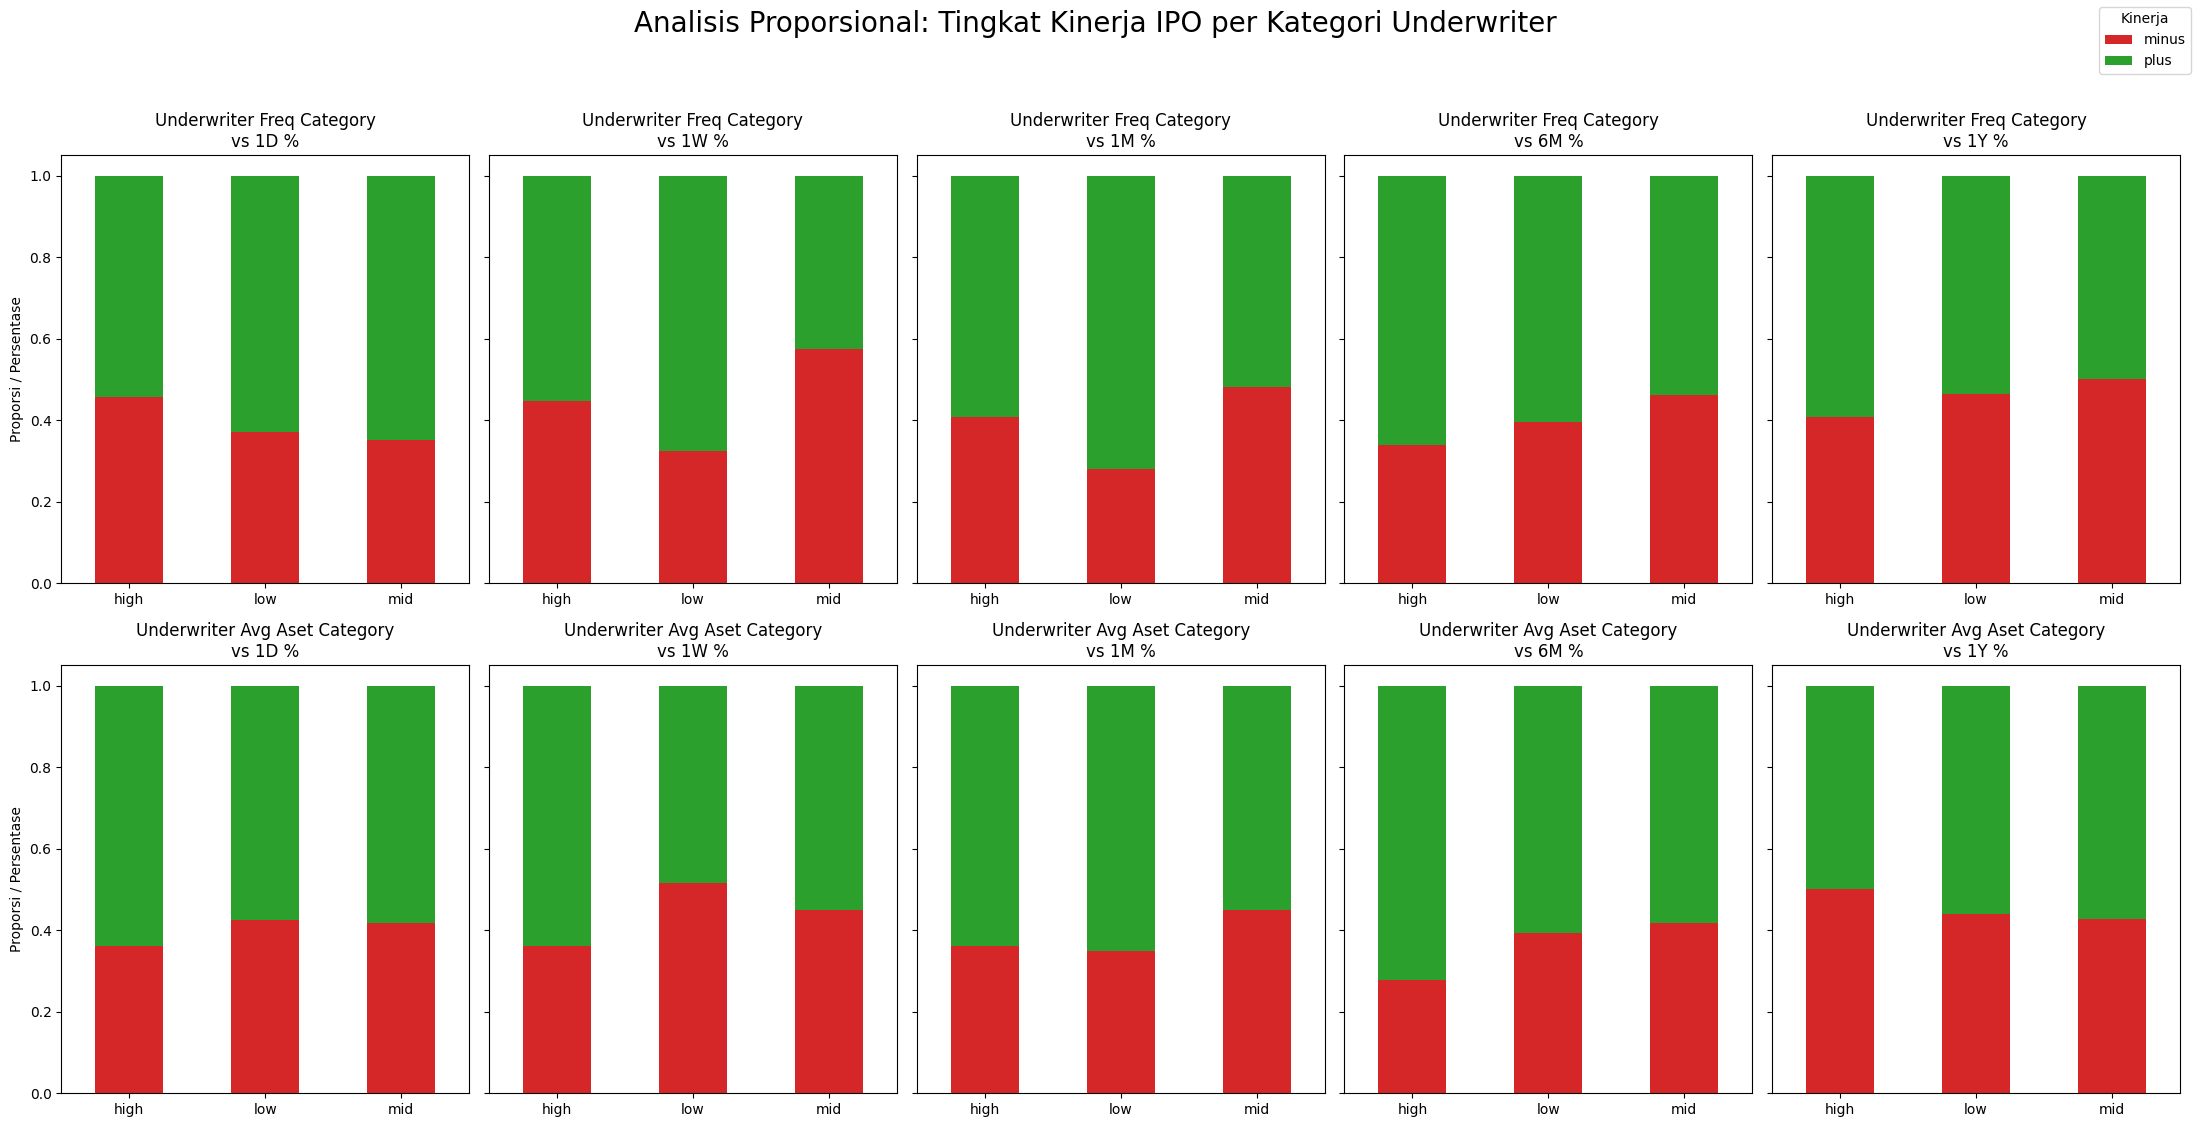

In [964]:
num_samples = 200
uw_freq_dist = ['high'] * 250 + ['mid'] * 150 + ['low'] * 100
uw_aset_dist = ['mid'] * 250 + ['low'] * 150 + ['high'] * 100

df_sim = pd.DataFrame({
    'underwriter_freq_category': np.random.choice(uw_freq_dist, num_samples),
    'underwriter_avg_aset_category': np.random.choice(uw_aset_dist, num_samples)
})

perf_outcomes = ['plus', 'minus']
for period in ['1D', '1W', '1M', '6M', '1Y']:
    probs = np.random.rand(num_samples)
    df_sim[f'perf_{period}'] = np.where(probs > 0.4, 'plus', 'minus')

fig, axes = plt.subplots(2, 5, figsize=(22, 11), sharey=True)
fig.suptitle('Analisis Proporsional: Tingkat Kinerja IPO per Kategori Underwriter', fontsize=20, y=1.02)
category_cols = ['underwriter_freq_category', 'underwriter_avg_aset_category']
perf_cols = [f'perf_{period}' for period in ['1D', '1W', '1M', '6M', '1Y']]
time_labels = ['1D %', '1W %', '1M %', '6M %', '1Y %']

colors = {'plus': '#2ca02c', 'minus': '#d62728'}

for row_idx, cat_col in enumerate(category_cols):
    for col_idx, (perf_col, time_label) in enumerate(zip(perf_cols, time_labels)):
        ax = axes[row_idx, col_idx]
        ct = pd.crosstab(df_sim[cat_col], df_sim[perf_col])
        ct_prop = ct.div(ct.sum(axis=1), axis=0)
        ct_prop.plot(kind='bar', stacked=True, ax=ax, color=[colors[c] for c in ct_prop.columns])
        ax.set_title(f'{cat_col.replace("_", " ").title()}\nvs {time_label}', fontsize=12)
        ax.set_ylabel('Proporsi / Persentase' if col_idx == 0 else '')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=0)
        ax.legend().set_visible(False)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Kinerja')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Gambar diatas nunjukin kalau tidak ada satu tipe underwriter terbaik untuk semua kondisi. Semua balik ke tujuan konsumen masing-masing.

##### Insight 1: Mau untung di hari pertama IPO
Berdasarkan Frekuensi (Baris Atas, Grafik 1D):
- Underwriter high-frequency memiliki tingkat keberhasilan (porsi hijau) yang paling tinggi, sekitar 70%.
- Underwriter mid-frequency dan low-frequency memiliki tingkat keberhasilan yang заметно lebih rendah, hanya sekitar 50-55%.

Berdasarkan Aset (Baris Bawah, Grafik 1D):
- Underwriter spesialis high-asset menunjukkan tingkat keberhasilan tertinggi, mendekati 80%.
- Semua kategori aset sebenarnya berkinerja baik di hari pertama (>70% sukses), namun kategori high sedikit unggul.

**Kesimpulan**: Untuk strategi "beli pagi jual sore" di hari IPO, memilih underwriter yang sering menangani IPO (high-freq) atau yang berspesialisasi pada perusahaan aset besar (high-asset) secara statistik memberikan peluang keberhasilan tertinggi.

##### Insight 2: Pola Anomali setelah 1 bulan IPO
Berdasarkan Frekuensi (Baris Atas, Grafik 1M):
- Underwriter low-frequency secara mengejutkan menunjukkan tingkat keberhasilan yang paling superior, dengan porsi hijau mencapai lebih dari 70%.
- Kinerja high-frequency dan mid-frequency justru biasa saja, dengan tingkat keberhasilan sekitar 52-55%.

Berdasarkan Aset (Baris Bawah, Grafik 1M):
- Pola serupa terjadi di sini. Underwriter spesialis low-asset memiliki tingkat keberhasilan tertinggi, mencapai hampir 80%.

**Kesimpulan**: Ini adalah temuan yang sangat menarik. Underwriter yang lebih kecil atau "butik" (low-freq dan low-asset) tampaknya lebih unggul dalam jangka waktu 1 bulan.

##### Insight 3: Performa Jangka Panjang (6 Bulan - 1 Tahun)
Berdasarkan Frekuensi (Baris Atas, Grafik 6M & 1Y):
- Underwriter mid-frequency secara konsisten menjadi yang terlemah, dengan tingkat keberhasilan hanya sekitar 55%.
- Baik underwriter high-frequency maupun low-frequency menunjukkan rekam jejak jangka panjang yang jauh lebih baik, dengan tingkat keberhasilan stabil di sekitar 70%.

Berdasarkan Aset (Baris Bawah, Grafik 6M & 1Y):
- Semua kategori aset menunjukkan kinerja jangka panjang yang sangat kuat, dengan tingkat keberhasilan mendekati 80%.
- Pada markah 1 tahun, spesialis high-asset dan mid-asset sedikit mengungguli low-asset, namun perbedaannya tidak signifikan.

**Kesimpulan**: Jika Anda adalah investor jangka panjang, sebaiknya hindari underwriter mid-frequency. Dari segi spesialisasi aset, tampaknya fundamental pasar secara umum cukup kuat untuk mengangkat kinerja mayoritas IPO setelah 6 bulan, terlepas dari ukuran aset awal perusahaan.

**Apakah underwriter untuk IPO ini sedang 'panas' (on a hot streak) atau 'dingin' (on a cold streak) berdasarkan kinerja terakhir mereka?**

Nah, kita akan catet di kolom baru yaitu `avg_last3_weighted`

In [965]:
weights_1d = {'minus': 0.33, 'plus': 0.67, 'ARA': 1}
weights_1w_1m = {'bad': 0.5, 'good': 1}
weights_rest = {'minus': 0.5, 'plus': 1}

df_sorted = df.sort_values('Tanggal Listing').reset_index(drop=True)

for col in ['1D %', '1W %', '1M %', '6M %', '1Y %']:
    if col == '1D %':
        weights = weights_1d
    elif col in ['1W %', '1M %']:
        weights = weights_1w_1m
    else:
        weights = weights_rest

    last3_dict = {}
    avg_last3_col = []
    for _, row in df_sorted.iterrows():
        underwriters = [uw.strip() for uw in row['Underwriter'].split(';') if uw.strip()]
        last3s = []
        for uw in underwriters:
            last3s.extend(last3_dict.get(uw, []))
        if last3s:
            avg_last3_col.append(np.mean([weights[v] for v in last3s if v in weights]))
        else:
            avg_last3_col.append(np.nan)

        val = row[col]
        if pd.notnull(val) and val in weights:
            for uw in underwriters:
                last3 = last3_dict.get(uw, [])
                last3.append(val)
                if len(last3) > 3:
                    last3 = last3[-3:]
                last3_dict[uw] = last3
    df_sorted[f'avg_last3_weighted_{col.replace(" ", "").replace("%", "pct").lower()}'] = avg_last3_col

**Apakah skor 'momentum' underwriter yang saya hitung benar-benar berkorelasi dengan kinerja IPO di dunia nyata?**

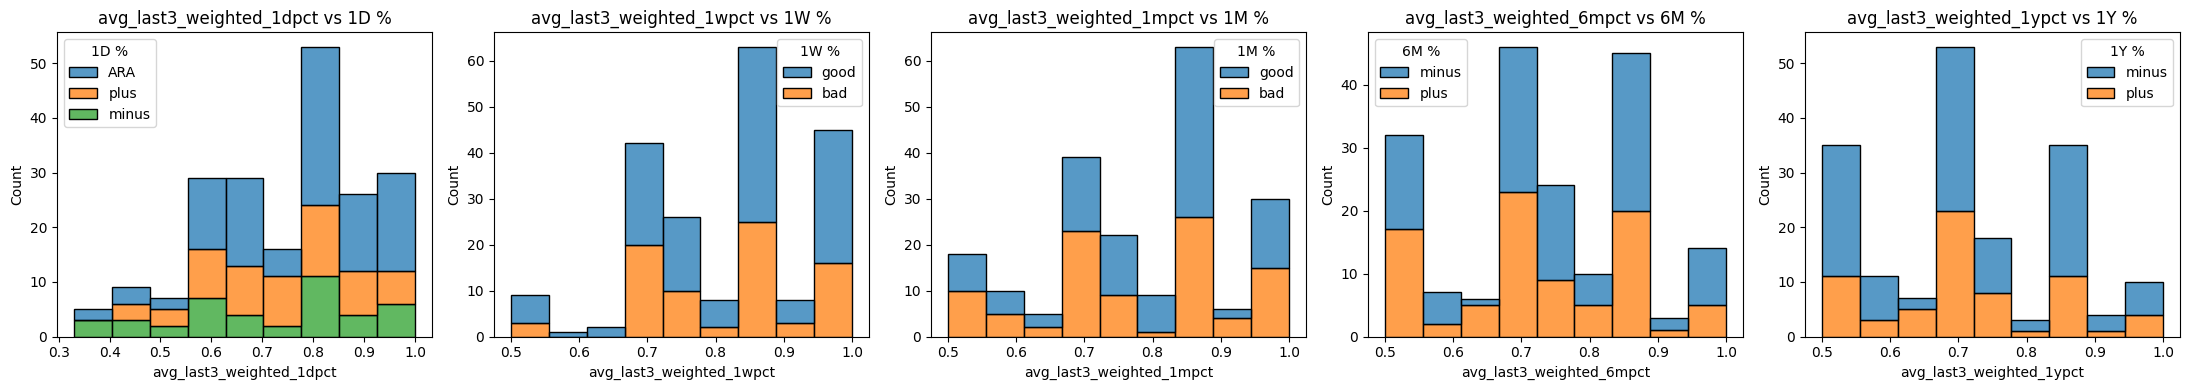

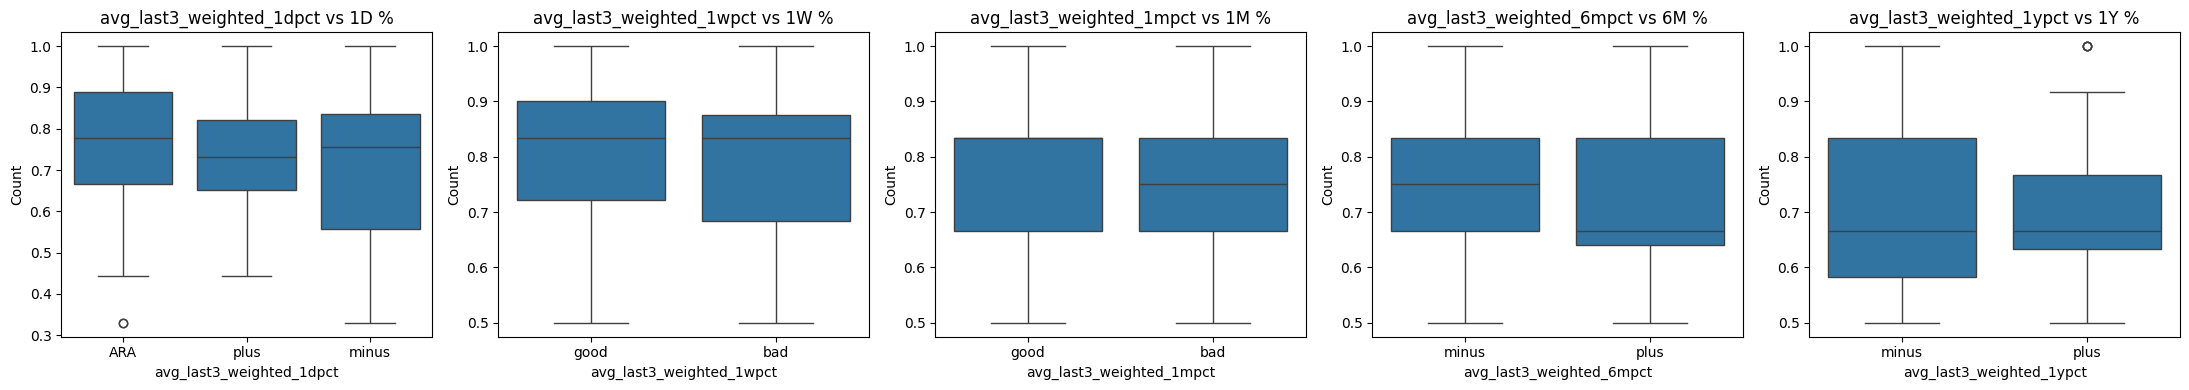

In [966]:
fig, axes = plt.subplots(1, 5, figsize=(22, 4))
plot_pairs = [
    ('avg_last3_weighted_1dpct', '1D %'),
    ('avg_last3_weighted_1wpct', '1W %'),
    ('avg_last3_weighted_1mpct', '1M %'),
    ('avg_last3_weighted_6mpct', '6M %'),
    ('avg_last3_weighted_1ypct', '1Y %'),
]

for i, (x_col, y_col) in enumerate(plot_pairs):
    sns.histplot(data=df_sorted, x=x_col, hue=y_col, multiple="stack", ax=axes[i], kde=False)
    axes[i].set_title(f'{x_col} vs {y_col}')
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(22, 4))
for i, (x_col, y_col) in enumerate(plot_pairs):
    sns.boxplot(data=df_sorted, x=y_col, y=x_col, ax=axes[i])
    axes[i].set_title(f'{x_col} vs {y_col}')
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

**Kesimpulan Histogram**: Fitur "rekam jejak" berhasil menangkap sinyal momentum. Skor yang lebih tinggi secara konsisten berkorelasi dengan probabilitas hasil yang lebih baik.

**Kesimpulan Box Plot**: Analisis ini secara statistik mengkonfirmasi bahwa IPO yang berkinerja baik cenderung berasal dari underwriter yang memiliki skor rekam jejak yang lebih tinggi, dan sebaliknya

Apakah ada hubungan antara tipe underwriter (berdasarkan frekuensi atau aset klien) dengan kinerja harga saham IPO dalam jangka pendek hingga panjang?

Insight:
1. 1D % tidak terlalu terlihat polanya jika dari frekuensi underwriter membawakan IPO dan rata-rata besarnya perusahaan yang biasa dibawahakannya
2. Underwriter yang biasanya membawakan perusahaan-perusahaan yang lebih besar cenderung memberikan kinerja yang lebih baik. Namun, ini dapat juga dikarenakan perusahaan yang lebih besar cenderung lebih baik kinerja IPO nya.
3. Frekuensi underwriter tidak terlalu terlihat polanya terhadap kinerja saham IPO yang dibawakannya.

Kemudian, ini yang kategoriin underwriter mana yang bagus, dibagi ke 3 kategori alpha(bagus) beta(lumayan) gamma(sisa). bikin kategorinya 3 biji, buat short term (1D), mid term (1M), long term (1Y)

In [967]:
label_cols = [
    '1D_ARA', '1D_plus', '1D_minus',
    #'1W_good', '1W_bad',
    '1M_good', '1M_bad',
    #'6M_plus', '6M_minus',
    '1Y_plus', '1Y_minus'
]

for col in label_cols:
    uw_df[col] = 0

uw_df.head()

underwriter  freq      avg_aset    avg_jumlah  \
0              PT Surya Fajar Sekuritas    11  1.894937e+11  1.059479e+11   
1                      PT BNI Sekuritas     9  3.898356e+13  4.461379e+12   
2                  PT Mandiri Sekuritas    15  2.824633e+13  6.182559e+12   
3      PT Citigroup Sekuritas Indonesia     2  2.134000e+13  6.393589e+12   
4  PT Credit Suisse Sekuritas Indonesia     6  4.180333e+13  8.209206e+12   

  avg_aset_category freq_category  1D_ARA  1D_plus  1D_minus  1M_good  1M_bad  \
0               low          high       0        0         0        0       0   
1              high          high       0        0         0        0       0   
2              high          high       0        0         0        0       0   
3              high           low       0        0         0        0       0   
4              high           mid       0        0         0        0       0   

   1Y_plus  1Y_minus  
0        0         0  
1        0         0  
2        0         0  
3        0         0  
4        0         0

Reset dulu sebentar

In [968]:
def reset_label_cols(uw_df, label_cols):
    uw_df[label_cols] = 0
    return uw_df

In [969]:
def update_uw_df_counts(df, uw_df):
    for idx, row in df.iterrows():
        val_1d = row['1D %']
        val_1m = row['1M %']
        val_1y = row['1Y %']
        underwriters = [uw.strip() for uw in row['Underwriter'].split(';') if uw.strip()]
        for uw in underwriters:
            uw_idx = uw_df[uw_df['underwriter'] == uw].index
            if not uw_idx.empty:
                uw_idx = uw_idx[0]

                if val_1d in ['ARA', 'plus', 'minus']:
                    col_1d = f"1D_{val_1d}"
                    if col_1d in uw_df.columns:
                        uw_df.at[uw_idx, col_1d] += 1

                if val_1m in ['good', 'bad']:
                    col_1m = f"1M_{val_1m}"
                    if col_1m in uw_df.columns:
                        uw_df.at[uw_idx, col_1m] += 1

                if val_1y in ['plus', 'minus']:
                    col_1y = f"1Y_{val_1y}"
                    if col_1y in uw_df.columns:
                        uw_df.at[uw_idx, col_1y] += 1
    return uw_df

In [970]:
uw_df['short_rep'] = 'gamma'
df_copy = df.copy()

while True:
    uw_df = reset_label_cols(uw_df, label_cols)
    uw_df = update_uw_df_counts(df_copy, uw_df)
    uw_df['score'] = uw_df['1D_ARA'] * 1 + uw_df['1D_minus'] * -1 + uw_df['1D_plus'] * 0.25

    top_uw_idx = uw_df['score'].idxmax()
    top_uw = uw_df.at[top_uw_idx, 'underwriter']
    top_score = uw_df.at[top_uw_idx, 'score']

    denominator = (
        float(uw_df.at[top_uw_idx, '1D_ARA'])
        + float(uw_df.at[top_uw_idx, '1D_plus'])
        + float(uw_df.at[top_uw_idx, '1D_minus'])
    )
    if denominator == 0:
        percentage_score = 0
    else:
        percentage_score = (
            float(uw_df.at[top_uw_idx, '1D_ARA'])
            + 0.25 * float(uw_df.at[top_uw_idx, '1D_plus'])
        ) / denominator

    if percentage_score < 0.4:
        break
    if percentage_score > 0.66 and (uw_df.at[top_uw_idx, '1D_ARA'] >= (uw_df.at[top_uw_idx, '1D_minus'] + uw_df.at[top_uw_idx, '1D_plus'])):
        uw_df.at[top_uw_idx, 'short_rep'] = 'alpha'
    else:
        uw_df.at[top_uw_idx, 'short_rep'] = 'beta'

    df_copy = df_copy[~df_copy['Underwriter'].str.contains(rf'\b{top_uw}\b', regex=True)]

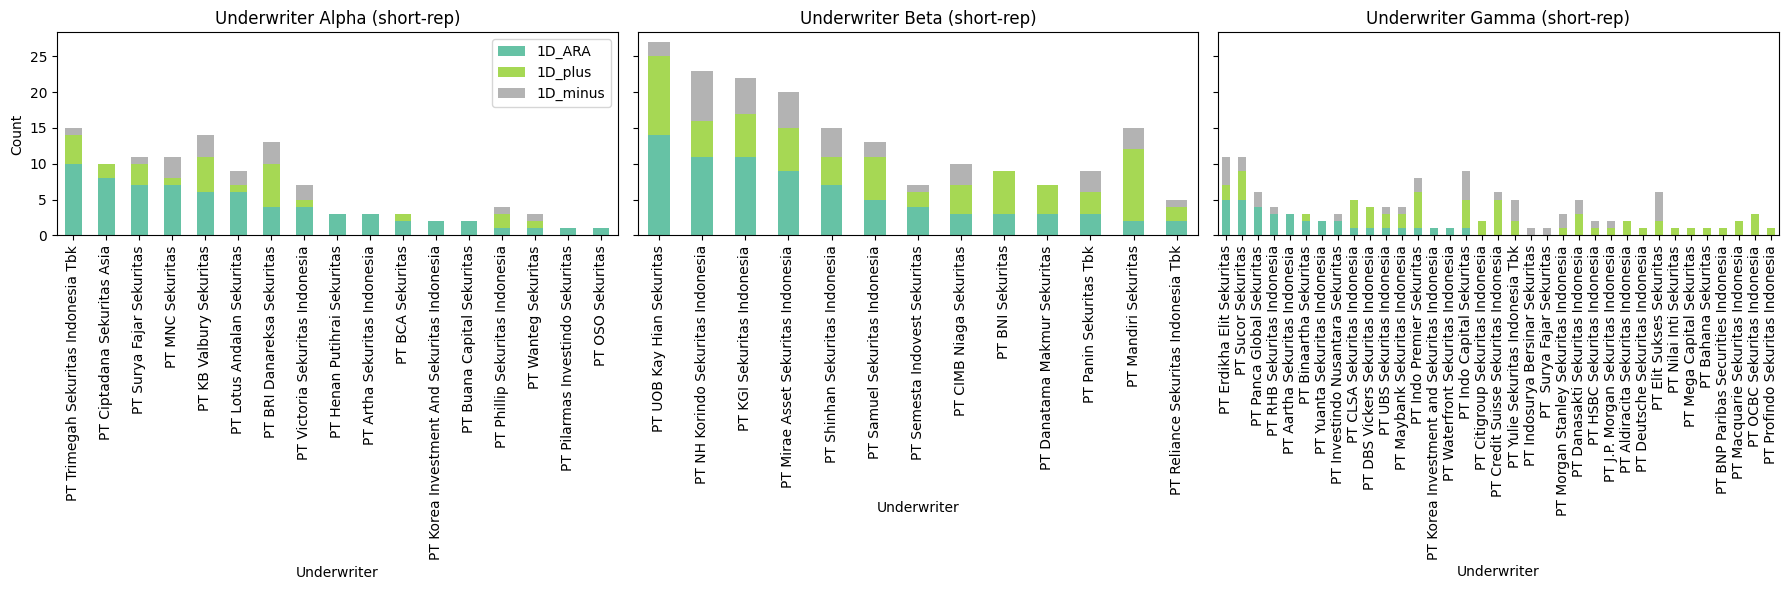

In [971]:
uw_df = reset_label_cols(uw_df, label_cols)
uw_df = update_uw_df_counts(df, uw_df)

groups = ['alpha', 'beta', 'gamma']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, group in enumerate(groups):
    subset = uw_df[uw_df['short_rep'] == group][['underwriter', '1D_ARA', '1D_plus', '1D_minus']]
    subset = subset.sort_values('1D_ARA', ascending=False)
    subset.set_index('underwriter', inplace=True)
    subset[['1D_ARA', '1D_plus', '1D_minus']].plot(
        kind='bar', stacked=True, ax=axes[i], legend=(i==0), colormap='Set2'
    )
    axes[i].set_title(f'Underwriter {group.capitalize()} (short-rep)')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Underwriter')
    axes[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

In [972]:
uw_df['mid_rep'] = 'gamma'
df_copy = df.copy()

while True:
    uw_df = reset_label_cols(uw_df, label_cols)
    uw_df = update_uw_df_counts(df_copy, uw_df)
    uw_df['score'] = uw_df['1M_good'] * 1 + uw_df['1M_bad'] * -1

    top_uw_idx = uw_df['score'].idxmax()
    top_uw = uw_df.at[top_uw_idx, 'underwriter']
    top_score = uw_df.at[top_uw_idx, 'score']

    denominator = (
        float(uw_df.at[top_uw_idx, '1M_good'])
        + float(uw_df.at[top_uw_idx, '1M_bad'])
    )
    if denominator == 0:
        percentage_score = 0
    else:
        percentage_score = float(uw_df.at[top_uw_idx, '1M_good']) / denominator

    if percentage_score < 0.5:
        break
    if percentage_score > 0.66:
        uw_df.at[top_uw_idx, 'mid_rep'] = 'alpha'
    else:
        uw_df.at[top_uw_idx, 'mid_rep'] = 'beta'

    df_copy = df_copy[~df_copy['Underwriter'].str.contains(rf'\b{top_uw}\b', regex=True)]

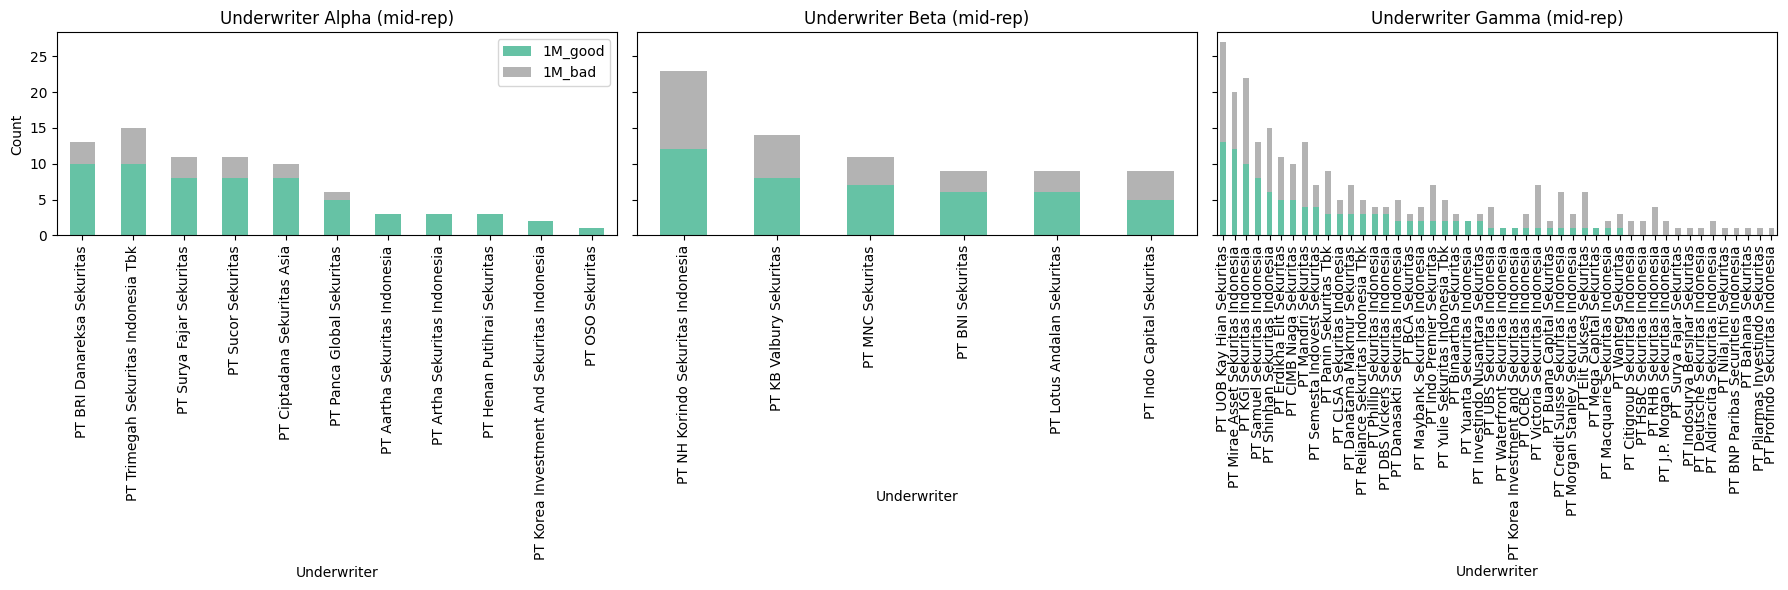

In [973]:
uw_df = reset_label_cols(uw_df, label_cols)
uw_df = update_uw_df_counts(df, uw_df)

groups = ['alpha', 'beta', 'gamma']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, group in enumerate(groups):
    subset = uw_df[uw_df['mid_rep'] == group][['underwriter', '1M_good', '1M_bad']]
    subset = subset.sort_values('1M_good', ascending=False)
    subset.set_index('underwriter', inplace=True)
    subset[['1M_good', '1M_bad']].plot(
        kind='bar', stacked=True, ax=axes[i], legend=(i==0), colormap='Set2'
    )
    axes[i].set_title(f'Underwriter {group.capitalize()} (mid-rep)')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Underwriter')
    axes[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()


In [974]:
uw_df['long_rep'] = 'gamma'
df_copy = df.copy()

while True:
    uw_df = reset_label_cols(uw_df, label_cols)
    uw_df = update_uw_df_counts(df_copy, uw_df)
    uw_df['score'] = uw_df['1Y_plus'] * 2 + uw_df['1Y_minus'] * -1

    top_uw_idx = uw_df['score'].idxmax()
    top_uw = uw_df.at[top_uw_idx, 'underwriter']
    top_score = uw_df.at[top_uw_idx, 'score']

    denominator = (
        float(uw_df.at[top_uw_idx, '1Y_plus'])
        + float(uw_df.at[top_uw_idx, '1Y_minus'])
    )
    if denominator == 0:
        percentage_score = 0
    else:
        percentage_score = float(uw_df.at[top_uw_idx, '1Y_plus']) / denominator

    if percentage_score < 0.4:
        break
    if percentage_score > 0.55:
        uw_df.at[top_uw_idx, 'long_rep'] = 'alpha'
    else:
        uw_df.at[top_uw_idx, 'long_rep'] = 'beta'

    df_copy = df_copy[~df_copy['Underwriter'].str.contains(rf'\b{top_uw}\b', regex=True)]

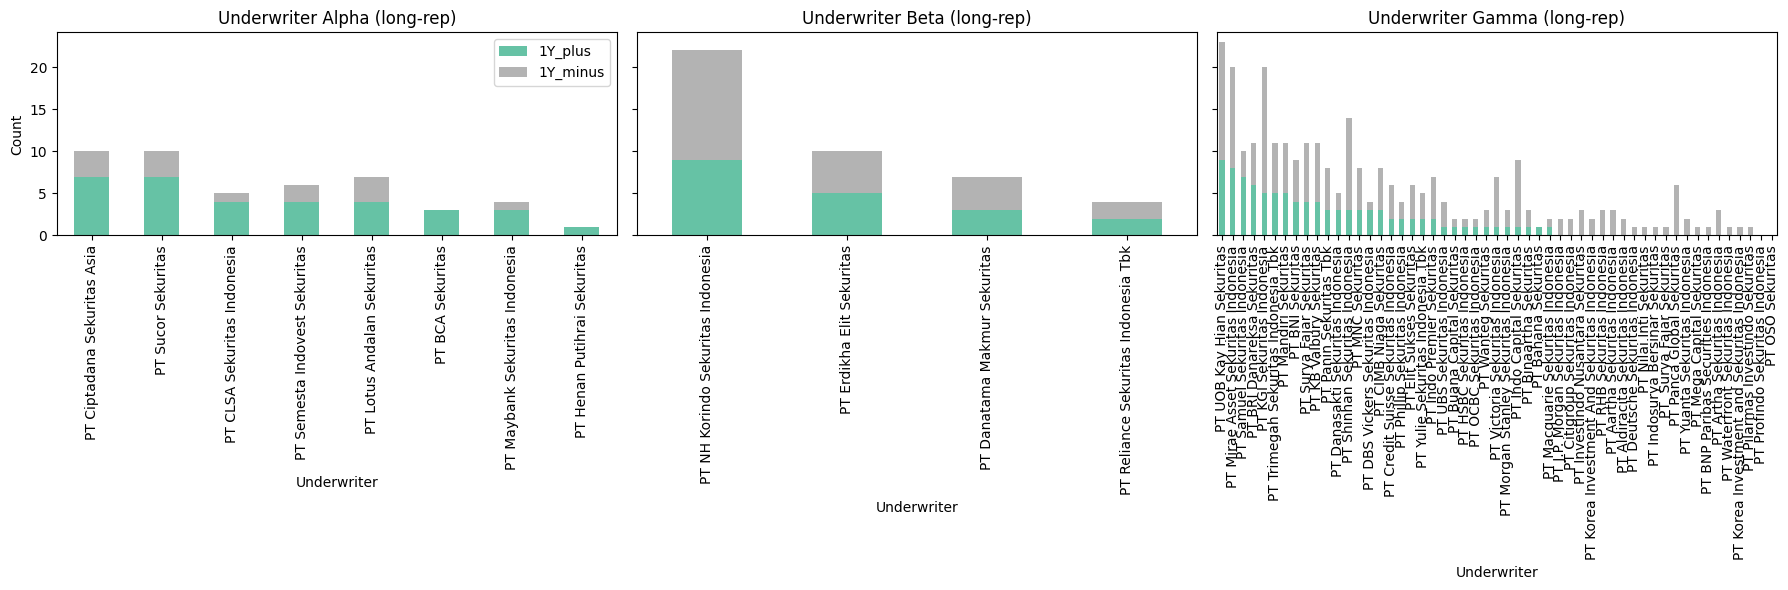

In [975]:
uw_df = reset_label_cols(uw_df, label_cols)
uw_df = update_uw_df_counts(df, uw_df)

groups = ['alpha', 'beta', 'gamma']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, group in enumerate(groups):
    subset = uw_df[uw_df['long_rep'] == group][['underwriter', '1Y_plus', '1Y_minus']]
    subset = subset.sort_values('1Y_plus', ascending=False)
    subset.set_index('underwriter', inplace=True)
    subset[['1Y_plus', '1Y_minus']].plot(
        kind='bar', stacked=True, ax=axes[i], legend=(i==0), colormap='Set2'
    )
    axes[i].set_title(f'Underwriter {group.capitalize()} (long-rep)')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Underwriter')
    axes[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

In [976]:
uw_df = reset_label_cols(uw_df, label_cols)
uw_df = update_uw_df_counts(df, uw_df)
uw_df = uw_df.drop(columns=['score'], errors='ignore')

In [977]:
big_banks_sekuritas = [
    'PT BNI Sekuritas',
    'PT Mandiri Sekuritas',
    'PT Citigroup Sekuritas Indonesia',
    'PT Credit Suisse Sekuritas Indonesia',
    'PT UOB Kay Hian Sekuritas',
    'PT BCA Sekuritas',
    'PT Mirae Asset Sekuritas Indonesia',
    'PT BRI Danareksa Sekuritas',
    'PT UBS Sekuritas Indonesia',
    'PT HSBC Sekuritas Indonesia',
    'PT J.P. Morgan Sekuritas Indonesia',
    'PT Morgan Stanley Sekuritas Indonesia',
    'PT CIMB Niaga Sekuritas',
    'PT CLSA Sekuritas Indonesia',
    'PT Maybank Sekuritas Indonesia',
    'PT DBS Vickers Sekuritas Indonesia',
    'PT Deutsche Sekuritas Indonesia',
    'PT Mega Capital Sekuritas',
    'PT Macquarie Sekuritas Indonesia',
    'PT BNP Paribas Securities Indonesia',
    'PT OCBC Sekuritas Indonesia'
]

In [978]:
uw_df['bigbank'] = 'no'

for idx, row in uw_df.iterrows():
    uw = row['underwriter']

    if uw in big_banks_sekuritas:
        uw_df.at[idx, 'bigbank'] = 'yes'

uw_df['bigbank'] = uw_df['bigbank'].astype('object')

In [979]:
df['underwriter_has_bigbank'] = 'no'

for idx, row in df.iterrows():
    underwriters = [uw.strip() for uw in row['Underwriter'].split(';') if uw.strip()]

    if any(uw in big_banks_sekuritas for uw in underwriters):
        df.at[idx, 'underwriter_has_bigbank'] = 'yes'

df['underwriter_has_bigbank'] = df['underwriter_has_bigbank'].astype('object')

Untuk pada dataset IPO, 'underwriter_highest_tier' melambangkan rank tertinggi underwriter yang ada, sedangkan 'underwriter_has_bigbank' menandakan ada big bank atau tidak pada underwriternya.

In [980]:
tier_rank = {'alpha': 1, 'beta': 2, 'gamma': 3}
rank_to_tier = {v: k for k, v in tier_rank.items()}

def process_row(row, uw_df, big_banks_sekuritas):
    underwriter_str = row.get('Underwriter', '')
    underwriters = [uw.strip() for uw in str(underwriter_str).split(';') if uw.strip()]

    uw_subset = uw_df[uw_df['underwriter'].isin(underwriters)]

    result = {}

    for rep_type in ['short', 'mid', 'long']:
        col = f'{rep_type}_rep'
        if not uw_subset.empty:
            tier_values = uw_subset[col].map(tier_rank).dropna()
            best_rank = tier_values.min()
            result[f'underwriter_highest_{rep_type}_rep'] = rank_to_tier[best_rank]
        else:
            result[f'underwriter_highest_{rep_type}_rep'] = None

    return pd.Series(result)

new_cols = df.apply(lambda row: process_row(row, uw_df, big_banks_sekuritas), axis=1)
df = df.join(new_cols)

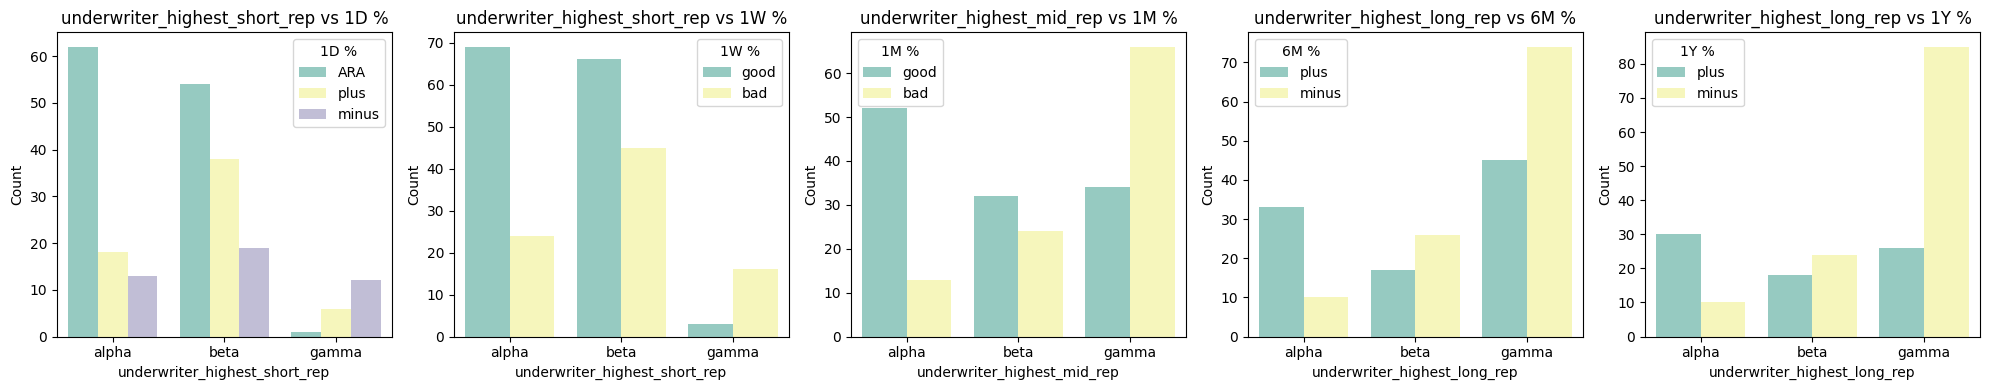

In [981]:
time_to_tier = {
    '1D %': 'underwriter_highest_short_rep',
    '1W %': 'underwriter_highest_short_rep',
    '1M %': 'underwriter_highest_mid_rep',
    '6M %': 'underwriter_highest_long_rep',
    '1Y %': 'underwriter_highest_long_rep',
}

custom_orders = {
    '1D %': ['ARA', 'plus', 'minus'],
    '1W %': ['good', 'bad'],
    '1M %': ['good', 'bad'],
    '6M %': ['plus', 'minus'],
    '1Y %': ['plus', 'minus']
}

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    x_col = time_to_tier[col]
    sns.countplot(x=df[x_col], hue=df[col], hue_order=custom_orders.get(col), ax=axes[i],
                    order=['alpha', 'beta', 'gamma'],
                    palette='Set3'
                    )
    axes[i].set_title(f'{x_col} vs {col}')
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

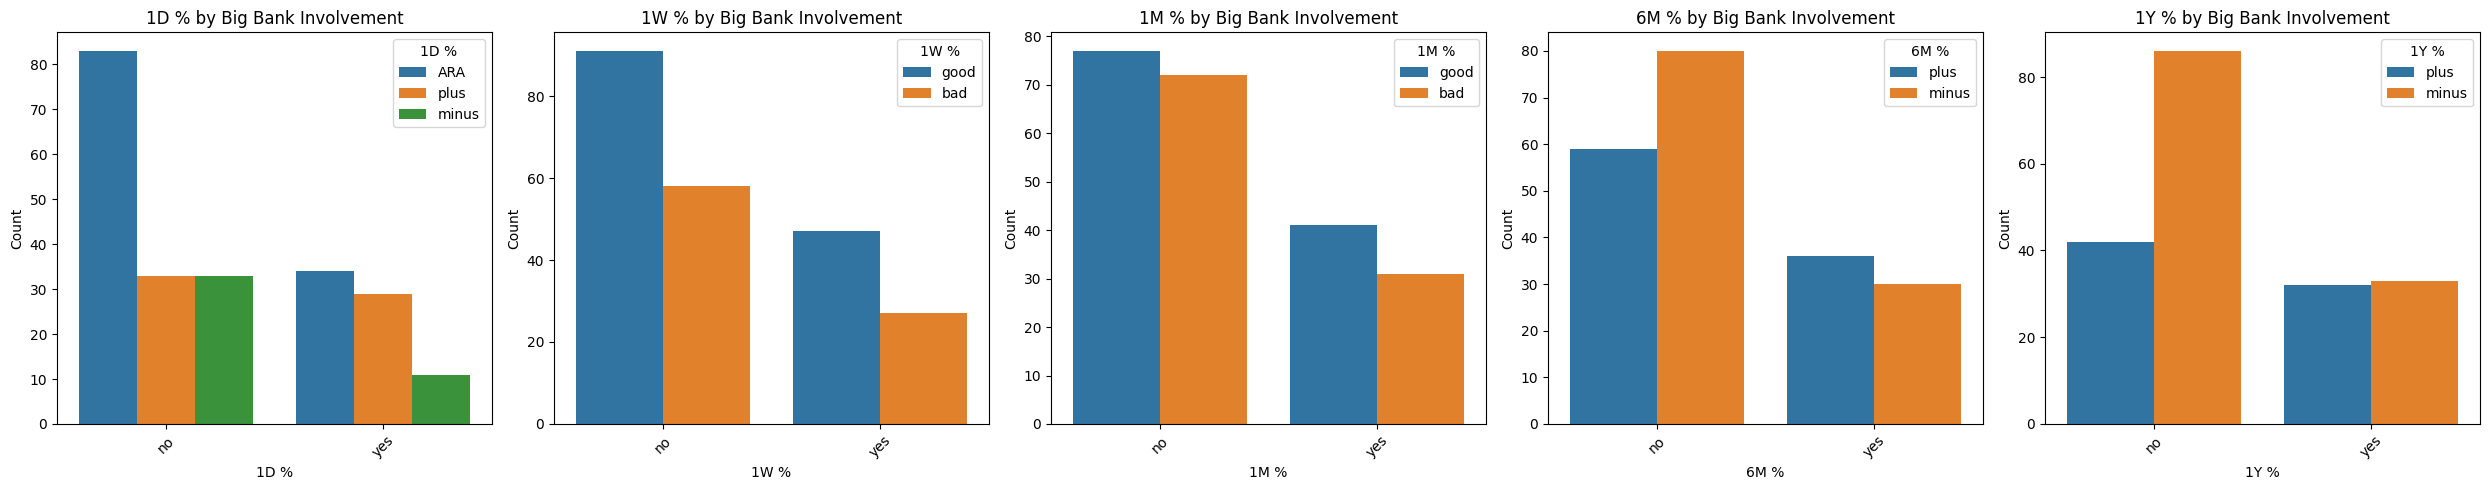

In [982]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
cols = ['1D %', '1W %', '1M %', '6M %', '1Y %']

for i, col in enumerate(cols):
    sns.countplot(data=df, x='underwriter_has_bigbank', hue=col, hue_order=custom_orders.get(col), ax=axes[i])
    axes[i].set_title(f"{col} by Big Bank Involvement")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- Untuk day 1, big bank terlihat lebih cenderung stabil saham IPO nya, sedangkan yang lainnya lebih volatil
- Terutama pada jangka panjang (6M, 1Y), bank besar terlihat mampu menjaga harganya dengan lebih baik

### 3. Seasonality

kolom yang mencatat kondisi musim, pada saat saham di listing

In [983]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Rainy'
    elif month in [3, 4, 5]:
        return 'Dry Early'
    elif month in [6, 7, 8]:
        return 'Dry Peak'
    elif month in [9, 10, 11]:
        return 'Dry Late'
    else:
        return 'Unknown'

df['Listing Month'] = df['Tanggal Listing'].dt.month
df['Listing Season'] = df['Listing Month'].apply(month_to_season)
df = df.drop(columns=['Listing Month', 'Tanggal Listing'])
df['Listing Season'].value_counts()

Listing Season
Rainy        74
Dry Peak     60
Dry Late     45
Dry Early    44
Name: count, dtype: int64

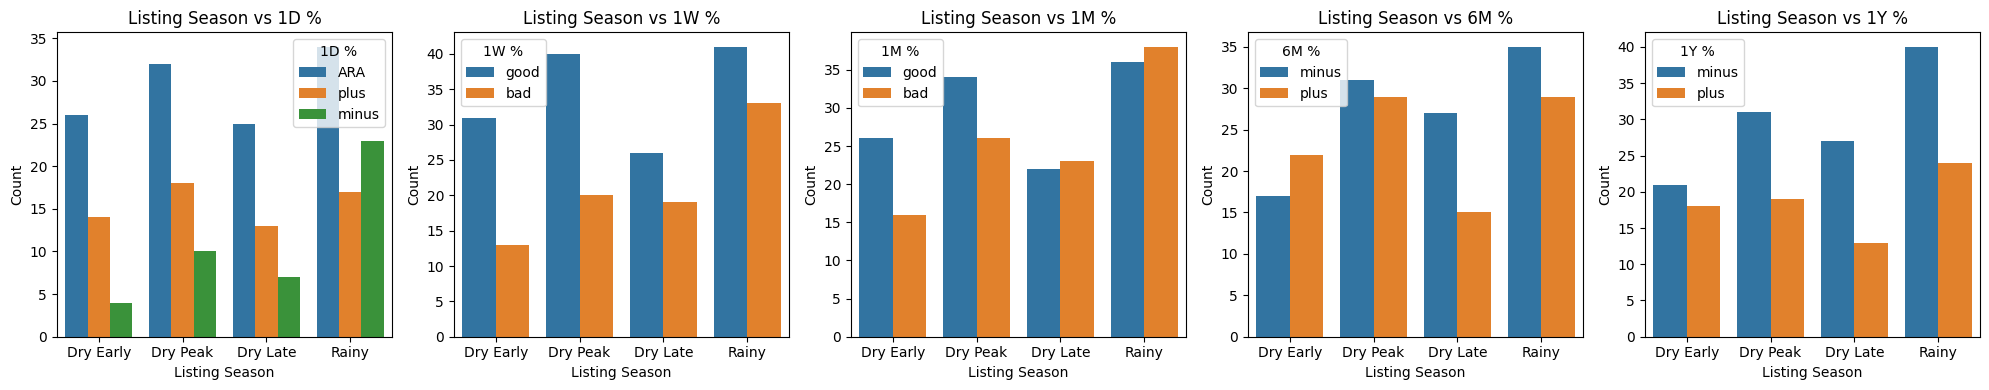

In [984]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    sns.countplot(x=df['Listing Season'], hue=df[col], ax=axes[i])
    axes[i].set_title(f'Listing Season vs {col}')
    axes[i].set_xlabel('Listing Season')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

### 4. Financials

In [985]:
df['ipo_raised_fund'] = df['Listed Share'] * df['Harga Final'] * df['Persen Saham Ditawarkan']

df['equity'] = df['Total Aset'] - df['Total Liabilitas']
df['leverage'] = df['Total Liabilitas'] / df['equity']
df['turnover'] = df['Pendapatan'] / df['Total Aset']


df['PER'] = df['Harga Final'] / (df['Laba Berjalan (Bukan Komperhensif)'] / df['Listed Share'])
df['PBV'] = df['Harga Final'] / (df['equity'] / df['Listed Share'])
df['PER'] = df['PER'].clip(upper=100)
df['PBV'] = df['PBV'].clip(upper=10)

df['ROA'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['Total Aset']
df['ROE'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['equity']
df['NPM'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['Pendapatan']

### 5. Drop yang ga guna

In [986]:
df = df.drop(['Listed Share', 'Rencana Penggunaan Dana IPO', 'Valuation Currency', 'Total Liabilitas', 'Laba Kotor', 'Laba Berjalan (Bukan Komperhensif)'], axis=1)

### 6. Total Aset (Numeric -> Category)

In [987]:
df['Total Aset'] = np.log1p(df['Total Aset'].clip(lower=1e-9))

In [988]:
df['total_aset_category'] = pd.cut(
    df['Total Aset'],
    bins=[-float('inf'), df['Total Aset'].quantile(0.25), df['Total Aset'].quantile(0.75), float('inf')],
    labels=['low', 'mid', 'high']
)

In [989]:
df['total_aset_category'] = df['total_aset_category'].astype('object')

### 7. Harga Final (Numeric -> Category)

In [990]:
df['Harga Final'] = np.log1p(df['Harga Final'])

In [991]:
df['price_category'] = pd.qcut(
    df['Harga Final'],
    q=4,
    labels=['very low', 'low', 'mid', 'high']
)

In [992]:
df['price_category'] = df['price_category'].astype('object')

In [993]:
# Map label dari '1Y %' (plus/minus) jadi numerik
df['1Y Label'] = df['1Y %'].map({'plus': 1, 'minus': 0})

# Inisialisasi threshold dan hasil akhir
threshold = 0.5
df_copy = df.copy()
underwriter_kategori = {}

# Ulangi proses hingga tidak ada lagi underwriter yang melebihi threshold
while True:
    # Hitung success rate tiap underwriter di data yang tersisa
    temp_ratio = (
        df_copy.groupby('lead_underwriter')['1Y Label']
        .agg(['sum', 'count'])
        .assign(success_rate=lambda x: x['sum'] / x['count'])
    )

    # Cek apakah ada yang di atas threshold
    valid = temp_ratio[temp_ratio['success_rate'] > threshold]
    if valid.empty:
        break

    # Ambil underwriter dengan success rate tertinggi
    best_underwriter = valid['success_rate'].idxmax()
    underwriter_kategori[best_underwriter] = 'Bagus'

    # Buang semua rows yang menggunakan underwriter ini
    df_copy = df_copy[df_copy['lead_underwriter'] != best_underwriter]

# Sisanya otomatis dianggap 'Jelek'
all_underwriters = df['lead_underwriter'].unique()
for u in all_underwriters:
    if u not in underwriter_kategori:
        underwriter_kategori[u] = 'Jelek'

# Mapping ke dataframe asli
df['underwriter_kualitas'] = df['lead_underwriter'].map(underwriter_kategori)


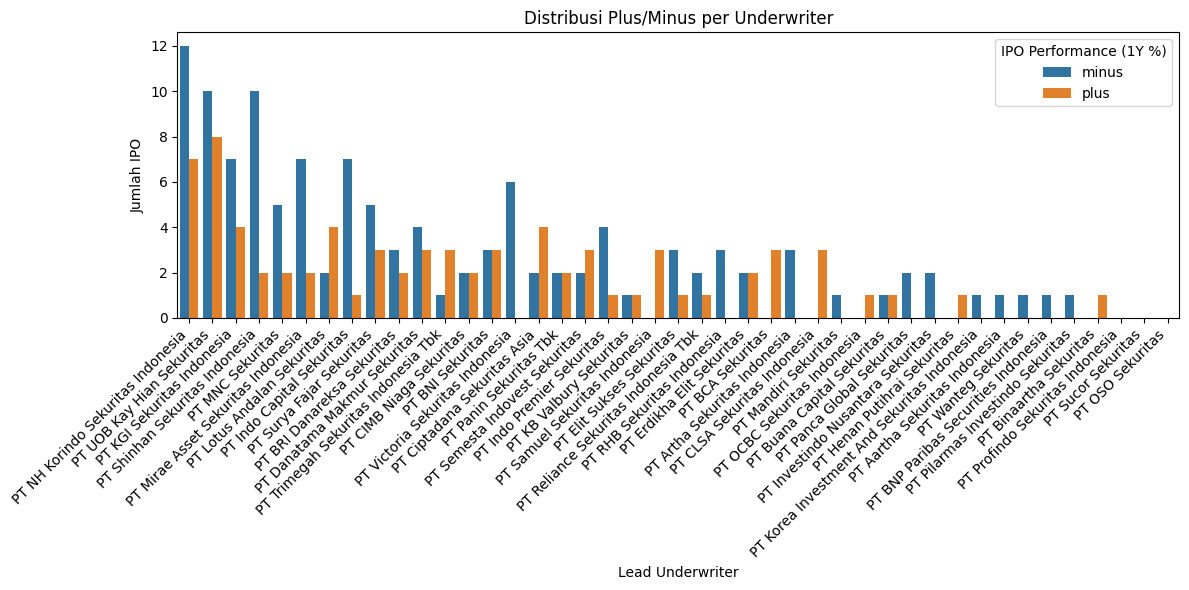

In [994]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df,
    x='lead_underwriter',
    hue='1Y %',
    order=df['lead_underwriter'].value_counts().index
)
plt.xticks(rotation=45, ha='right')
plt.title('Distribusi Plus/Minus per Underwriter')
plt.xlabel('Lead Underwriter')
plt.ylabel('Jumlah IPO')
plt.legend(title='IPO Performance (1Y %)')
plt.tight_layout()
plt.show()

In [995]:
df.drop(columns=['1Y Label'], inplace=True)

In [996]:
underwriter_success = (
    df.groupby('lead_underwriter')['1Y %']
    .apply(lambda x: (x == 'plus').mean())
    .sort_values(ascending=False)
)

df['underwriter_success_rank'] = df['lead_underwriter'].map(underwriter_success.rank(ascending=False))

## Encoding

In [997]:
df = df.drop('Ticker', axis = 1)
df = df.drop('Nama Perusahaan', axis = 1)

In [998]:
categorical_cols = df.select_dtypes(include='object').drop(columns=['Underwriter'])
for col in categorical_cols:
    if col != 'Underwriter' and col != 'lead_underwriter':
        print(f"{col}:")
        print(df[col].unique())
        print('-' * 40)

Sektor:
['Energy' 'Basic Materials' 'Financials' 'Healthcare' 'Technology'
 'Transportation & Logistic' 'Consumer Non-Cyclicals' 'Industrials'
 'Consumer Cyclicals' 'Infrastructures' 'Properties & Real Estate']
----------------------------------------
Papan Pencatatan:
['utama' 'pengembangan' 'pemantauan khusus' 'akselerasi' 'ekonomi baru']
----------------------------------------
Ownership:
['lainnya' 'konglomerat' 'start up' 'bumn']
----------------------------------------
1D %:
['ARA' 'plus' 'minus']
----------------------------------------
1W %:
['good' 'bad']
----------------------------------------
1M %:
['good' 'bad' nan]
----------------------------------------
6M %:
['minus' 'plus' nan]
----------------------------------------
1Y %:
['minus' 'plus' nan]
----------------------------------------
underwriter_freq_category:
['high' 'mid' 'low']
----------------------------------------
underwriter_avg_aset_category:
['low' 'high' 'mid']
----------------------------------------
unde

In [999]:
df['price_category'].value_counts()

price_category
very low    58
high        56
mid         55
low         54
Name: count, dtype: int64

In [1000]:
manual_orders = {
    'Papan Pencatatan': ['utama', 'pengembangan', 'akselerasi', 'ekonomi baru', 'pemantauan khusus'],
    'Ownership': ['bumn', 'konglomerat', 'start up', 'lainnya'],
    'underwriter_freq_category': ['low', 'mid', 'high'],
    'underwriter_avg_aset_category': ['low', 'mid', 'high'],
    'Listing Quartal': ['I', 'II', 'III', 'IV'],
    'total_aset_category': ['low', 'mid', 'high'],
    'price_category': ['very low', 'high', 'mid', 'low'],
    'underwriter_highest_short_rep' : ['gamma', 'beta', 'alpha'],
    'underwriter_highest_mid_rep' : ['gamma', 'beta', 'alpha'],
    'underwriter_highest_long_rep' : ['gamma', 'beta', 'alpha'],
    'underwriter_has_bigbank' : ['no', 'yes']
}

label_encoders = {}
encoded_mappings = {}

for col in categorical_cols:
    if col in manual_orders:
        mapping = {v: i for i, v in enumerate(manual_orders[col])}
        df[col] = df[col].map(lambda x: mapping[x] if pd.notna(x) else np.nan)
        encoded_mappings[col] = mapping
        label_encoders[col] = 'manual'
    else:
        le = LabelEncoder()
        df[col] = df[col].astype("str")
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
        encoded_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

    df[col] = pd.to_numeric(df[col], errors='coerce')

In [1001]:
for col, mapping in encoded_mappings.items():
    print(f"{col}: {mapping}")

Sektor: {'Basic Materials': np.int64(0), 'Consumer Cyclicals': np.int64(1), 'Consumer Non-Cyclicals': np.int64(2), 'Energy': np.int64(3), 'Financials': np.int64(4), 'Healthcare': np.int64(5), 'Industrials': np.int64(6), 'Infrastructures': np.int64(7), 'Properties & Real Estate': np.int64(8), 'Technology': np.int64(9), 'Transportation & Logistic': np.int64(10)}
Papan Pencatatan: {'utama': 0, 'pengembangan': 1, 'akselerasi': 2, 'ekonomi baru': 3, 'pemantauan khusus': 4}
Ownership: {'bumn': 0, 'konglomerat': 1, 'start up': 2, 'lainnya': 3}
1D %: {'ARA': np.int64(0), 'minus': np.int64(1), 'plus': np.int64(2)}
1W %: {'bad': np.int64(0), 'good': np.int64(1)}
1M %: {'bad': np.int64(0), 'good': np.int64(1), 'nan': np.int64(2)}
6M %: {'minus': np.int64(0), 'nan': np.int64(1), 'plus': np.int64(2)}
1Y %: {'minus': np.int64(0), 'nan': np.int64(1), 'plus': np.int64(2)}
lead_underwriter: {'PT Aartha Sekuritas Indonesia': np.int64(0), 'PT Artha Sekuritas Indonesia': np.int64(1), 'PT BCA Sekuritas': n

## Correlation

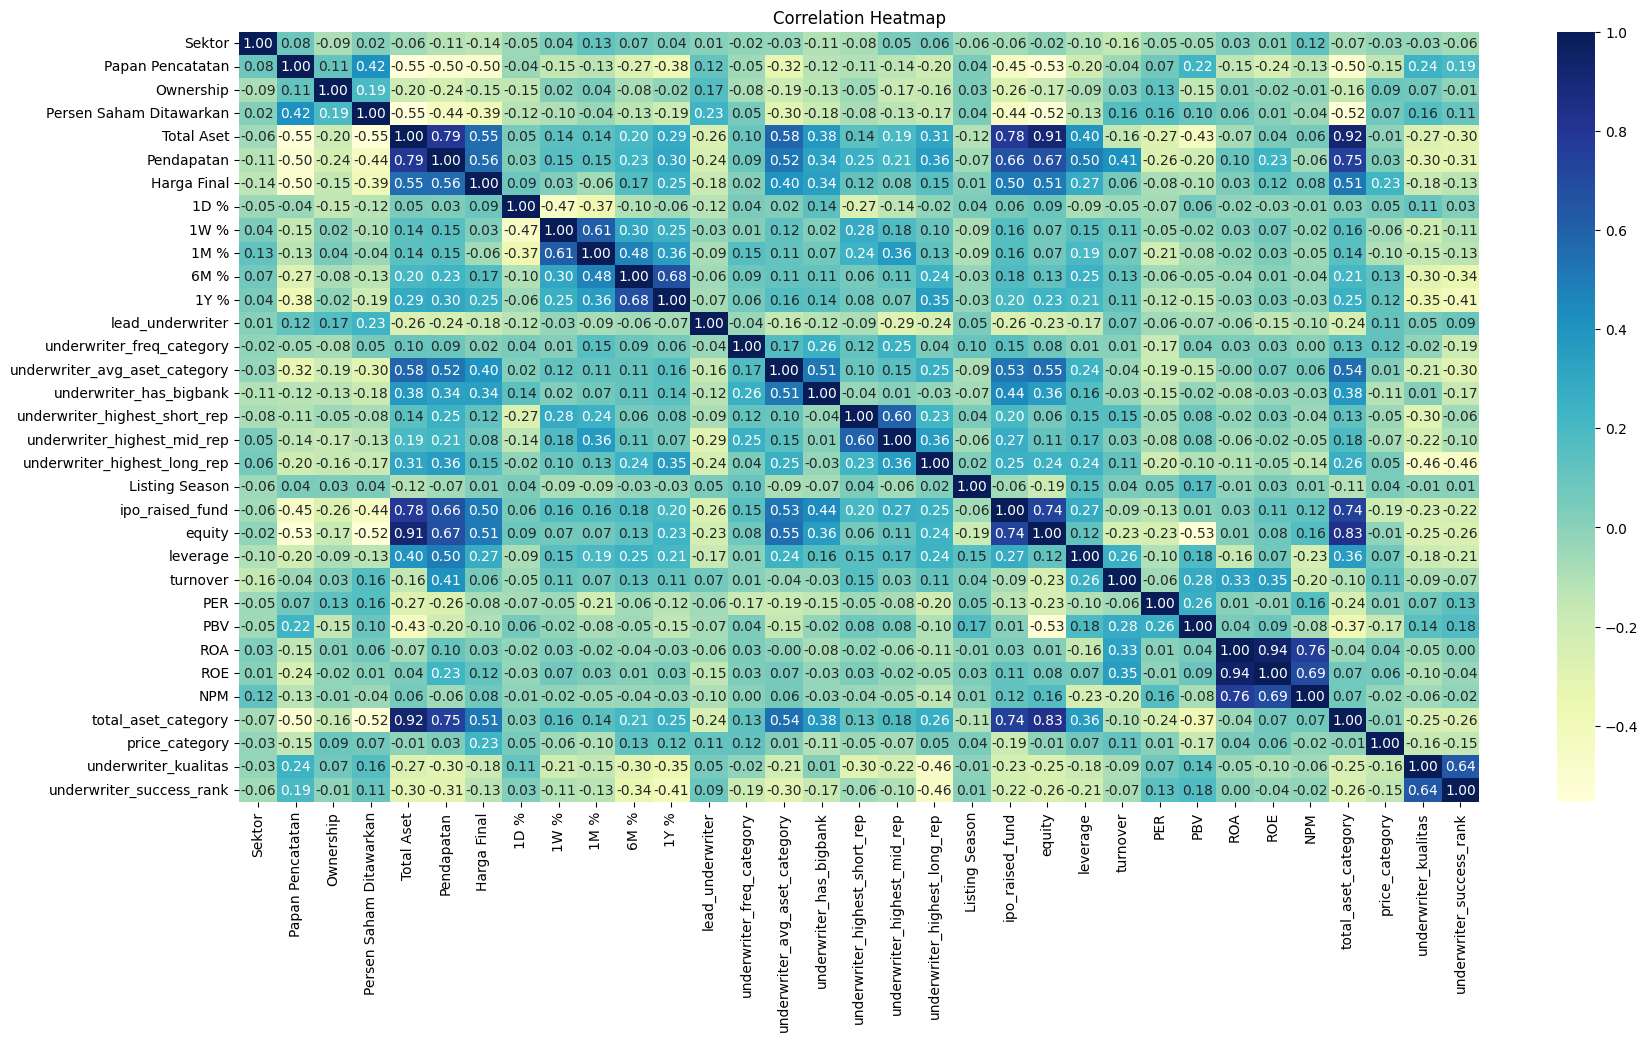

In [1002]:
corr_df = df.drop(columns=['Underwriter'])
corr_matrix = corr_df.corr(method='spearman')

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

## Final Columns

In [1003]:
custom_columns = [
    ('Ownership', 'ownership'),
    ('Papan Pencatatan', 'papan_pencatatan'),
    ('ipo_raised_fund', 'ipo_raised_fund'),
    ('Persen Saham Ditawarkan', 'float'),
    ('price_category', 'price_cat'),

    ('lead_underwriter', 'lead_underwriter'),
    ('underwriter_freq_category', 'underwriter_freq_cat'),
    ('underwriter_avg_aset_category', 'underwriter_avg_aset_cat'),
    ('underwriter_highest_short_rep', 'underwriter_highest_short_rep'),
    ('underwriter_highest_mid_rep', 'underwriter_highest_mid_rep'),
    ('underwriter_highest_long_rep', 'underwriter_highest_long_rep'),
    ('underwriter_has_bigbank', 'underwriter_has_bigbank'),
    ('underwriter_success_rank', 'underwriter_success_rank'),
    ('Listing Season', 'listing_season'),
    ('Harga Final', 'harga_final'),

    ('total_aset_category', 'total_aset_cat'),
    ('equity', 'equity'),
    ('leverage', 'leverage_ratio'),
    ('Pendapatan', 'revenue'),
    ('turnover', 'turnover_ratio'),
    ('PER', 'per'),
    ('PBV', 'pbv'),
    ('ROE', 'roe'),

    ('1D %', '1d'),
    ('1W %', '1w'),
    ('1M %', '1m'),
    ('6M %', '6m'),
    ('1Y %', '1y'),
]

orig_cols, new_names = zip(*custom_columns)

df_custom = df[list(orig_cols)].copy()
df_custom.columns = new_names

df_custom.head()

ownership  papan_pencatatan  ipo_raised_fund   float  price_cat  \
0          3                 0     3.541024e+10  0.0956          3   
1          1                 1     2.793938e+12  0.1500          1   
2          3                 4     6.183591e+11  0.1500          1   
3          1                 0     2.123667e+11  0.0726          1   
4          3                 1     5.000000e+10  0.2500          0   

   lead_underwriter  underwriter_freq_cat  underwriter_avg_aset_cat  \
0                38                     2                         0   
1                 3                     2                         2   
2                 2                     1                         1   
3                10                     2                         1   
4                38                     2                         1   

   underwriter_highest_short_rep  underwriter_highest_mid_rep  ...  \
0                              2                            2  ...   
1                              1                            1  ...   
2                              2                            0  ...   
3                              2                            2  ...   
4                              2                            2  ...   

        revenue  turnover_ratio         per       pbv       roe  1d  1w  1m  \
0  2.710000e+11        0.501852  -65.942673  1.356777 -0.020575   0   1   1   
1  4.960000e+12        0.546256   12.500839  8.390203  0.671171   2   0   0   
2  1.210000e+12        0.056279   38.170315  2.169681  0.056842   0   0   0   
3  1.150000e+12        0.532407   24.789504  2.785868  0.112381   0   1   1   
4  1.940000e+11        4.292289  100.000000  6.485393  0.017624   0   1   1   

   6m  1y  
0   0   0  
1   0   0  
2   2   2  
3   2   2  
4   2   2  

[5 rows x 28 columns]

## Training

In [1004]:
!pip install tabpfn

In [1005]:
df_custom.head()

ownership  papan_pencatatan  ipo_raised_fund   float  price_cat  \
0          3                 0     3.541024e+10  0.0956          3   
1          1                 1     2.793938e+12  0.1500          1   
2          3                 4     6.183591e+11  0.1500          1   
3          1                 0     2.123667e+11  0.0726          1   
4          3                 1     5.000000e+10  0.2500          0   

   lead_underwriter  underwriter_freq_cat  underwriter_avg_aset_cat  \
0                38                     2                         0   
1                 3                     2                         2   
2                 2                     1                         1   
3                10                     2                         1   
4                38                     2                         1   

   underwriter_highest_short_rep  underwriter_highest_mid_rep  ...  \
0                              2                            2  ...   
1                              1                            1  ...   
2                              2                            0  ...   
3                              2                            2  ...   
4                              2                            2  ...   

        revenue  turnover_ratio         per       pbv       roe  1d  1w  1m  \
0  2.710000e+11        0.501852  -65.942673  1.356777 -0.020575   0   1   1   
1  4.960000e+12        0.546256   12.500839  8.390203  0.671171   2   0   0   
2  1.210000e+12        0.056279   38.170315  2.169681  0.056842   0   0   0   
3  1.150000e+12        0.532407   24.789504  2.785868  0.112381   0   1   1   
4  1.940000e+11        4.292289  100.000000  6.485393  0.017624   0   1   1   

   6m  1y  
0   0   0  
1   0   0  
2   2   2  
3   2   2  
4   2   2  

[5 rows x 28 columns]

## Feature Selections

In [1006]:
from typing import List, Dict

def select_features_by_kendall_improved(
    df: pd.DataFrame,
    target_cols: List[str],
    threshold: float = 0.075,
    max_features: int = 8,
    corr_cutoff: float = 0.7
) -> Dict[str, List[str]]:
    """
    Memilih fitur terbaik untuk setiap kolom target berdasarkan korelasi Kendall,
    sambil mengontrol multikolinearitas.

    Args:
        df (pd.DataFrame): DataFrame input yang berisi fitur dan target.
        target_cols (List[str]): Daftar nama kolom target.
        threshold (float): Nilai absolut korelasi Kendall minimum antara fitur dan target.
        max_features (int): Jumlah maksimum fitur yang akan dipilih untuk setiap target.
        corr_cutoff (float): Batas korelasi absolut maksimum yang diizinkan antar fitur terpilih.

    Returns:
        Dict[str, List[str]]: Dictionary dengan key nama kolom target dan value list nama fitur terpilih.
    """

    try:
        corr_matrix = df.corr(method="kendall")
    except TypeError:
        print("Error: Pastikan semua kolom dalam DataFrame numerik untuk menghitung korelasi.")
        df_numeric = df.apply(pd.to_numeric, errors='coerce').dropna(axis=1)
        corr_matrix = df_numeric.corr(method="kendall")
        print("Melanjutkan dengan kolom numerik yang valid...")


    all_potential_features = [col for col in corr_matrix.columns if col not in target_cols]
    selected_features_per_target = {}

    for target in target_cols:
        if target not in corr_matrix.columns:
            print(f"Peringatan: Kolom target '{target}' tidak ada di DataFrame. Dilewati.")
            continue

        target_corr = corr_matrix.loc[all_potential_features, target]

        top_features = target_corr[abs(target_corr) >= threshold].abs().sort_values(ascending=False)

        selected = []
        for feature in top_features.index:
            if len(selected) >= max_features:
                break
            if selected:
                correlations_with_selected = corr_matrix.loc[feature, selected].abs()
                if correlations_with_selected.max() > corr_cutoff:
                    continue
            selected.append(feature)
        selected_features_per_target[target] = selected
    return selected_features_per_target

In [1007]:
targets = ["1d", "1w", "1m", "6m", "1y"]

selected_features = select_features_by_kendall(df_custom, targets)

features_to_use = {}

for target, features in selected_features.items():
    print(f"Target: {target} -> Features: {features}")
    features_to_use[target] = features

Target: 1d -> Features: ['underwriter_has_bigbank', 'lead_underwriter', 'float', 'underwriter_highest_mid_rep', 'ownership', 'underwriter_highest_short_rep']
Target: 1w -> Features: ['underwriter_highest_short_rep', 'underwriter_highest_mid_rep', 'total_aset_cat', 'ipo_raised_fund', 'revenue', 'leverage_ratio', 'underwriter_avg_aset_cat', 'underwriter_highest_long_rep']
Target: 1m -> Features: ['underwriter_highest_mid_rep', 'underwriter_highest_short_rep', 'leverage_ratio', 'underwriter_freq_cat', 'total_aset_cat', 'ipo_raised_fund', 'revenue', 'underwriter_highest_long_rep']
Target: 6m -> Features: ['underwriter_highest_long_rep', 'leverage_ratio', 'total_aset_cat', 'revenue', 'ipo_raised_fund', 'harga_final', 'price_cat', 'underwriter_has_bigbank']
Target: 1y -> Features: ['underwriter_highest_long_rep', 'revenue', 'total_aset_cat', 'harga_final', 'leverage_ratio', 'ipo_raised_fund', 'underwriter_avg_aset_cat', 'underwriter_has_bigbank']


### 1Y %

#### TabPFN

In [1008]:
df_custom['1y'].value_counts()

1y
0    119
2     74
1     30
Name: count, dtype: int64

In [1009]:
X = df_custom[features_to_use['1y']].copy()
y = df_custom['1y'].copy()

X = X[y != 1]
y = y[y != 1]

y = y.replace({2: 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)

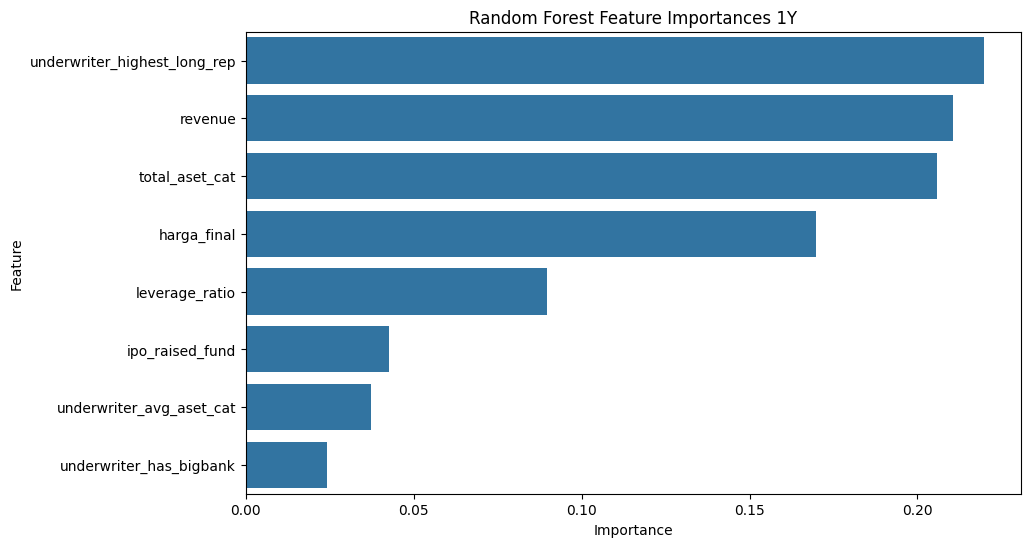

In [1010]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

importances = rf.feature_importances_
importances = pd.Series(importances, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features_to_use['1y'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances 1Y")
plt.show()

In [1011]:
import torch
from tabpfn import TabPFNClassifier

clf = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu")

clf.fit(X_train, y_train)

TabPFNClassifier(device='cpu')

In [1012]:
y_pred = clf.predict(X_test)

In [1013]:
thresholds = np.arange(0.3, 0.61, 0.01)
f1_scores = []

probs = cross_val_predict(
    clf,
    X, y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method='predict_proba'
)[:, 1]

for t in thresholds:
    preds = (probs >= t).astype(int)
    score = f1_score(y, preds, average='macro')
    f1_scores.append(score)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Macro Score: {best_f1:.4f}")

Best Threshold: 0.46
Best F1 Macro Score: 0.6983


Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        24
           1       1.00      0.73      0.85        15

    accuracy                           0.90        39
   macro avg       0.93      0.87      0.88        39
weighted avg       0.91      0.90      0.89        39



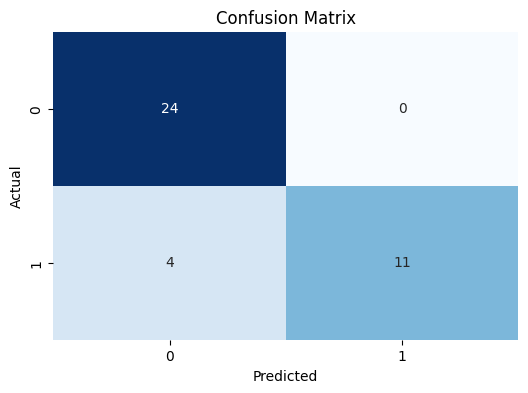

In [1014]:
probs = clf.predict_proba(X_test)[:, 1]
y_pred = (probs > best_threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

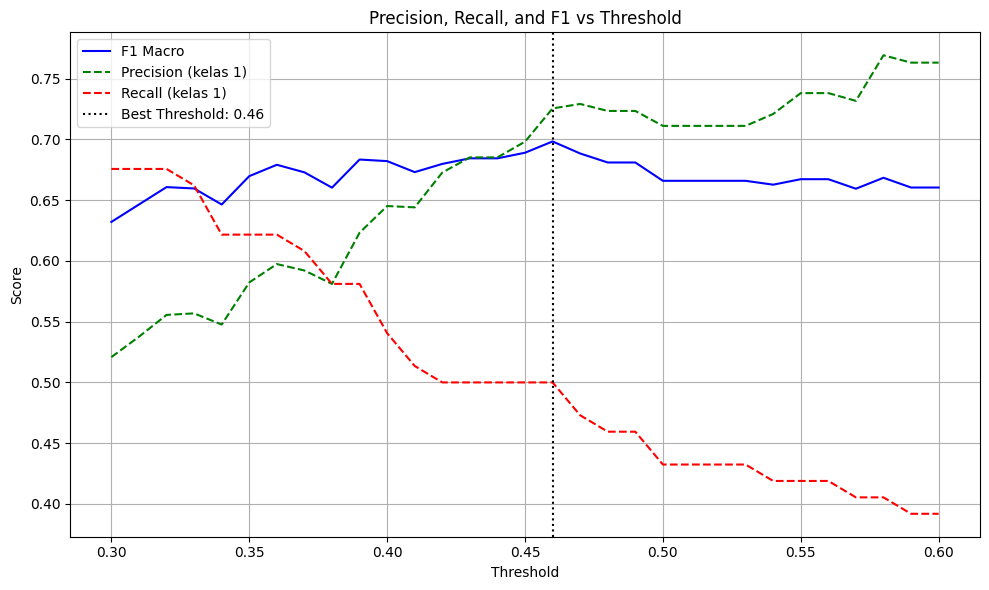

In [1015]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
probs = cross_val_predict(
    clf,
    X, y,
    cv=cv,
    method='predict_proba'
)[:, 1]

f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    f1_scores.append(f1_score(y, preds, average='macro'))
    precisions.append(precision_score(y, preds))
    recalls.append(recall_score(y, preds))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Macro', color='blue')
plt.plot(thresholds, precisions, label='Precision (kelas 1)', linestyle='--', color='green')
plt.plot(thresholds, recalls, label='Recall (kelas 1)', linestyle='--', color='red')
plt.axvline(best_threshold, linestyle=':', color='black', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1016]:
threshold = best_threshold
preds = (probs >= threshold).astype(int)

cm = confusion_matrix(y, preds)
print(f"F1 Score (threshold={threshold}): {f1_score(y, preds, average='macro'):.4f}")
print(f"Accuracy: {accuracy_score(y, preds)}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

F1 Score (threshold=0.46000000000000013): 0.6983
Accuracy: 0.7357512953367875


##### MLFlow

In [1017]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 14.5 MB/s eta 0:00:00


In [1018]:
import mlflow
import mlflow.sklearn
from tabpfn import TabPFNClassifier

mlflow.set_experiment("tabpfn-ipo-prediction")
mlflow.set_tracking_uri("file:/content/mlruns")

2025/07/08 15:13:24 INFO mlflow.tracking.fluent: Experiment with name 'tabpfn-ipo-prediction' does not exist. Creating a new experiment.


In [1019]:
with mlflow.start_run(run_name="tabpfn_run"):
    clf = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu")

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_macro", f1)

    mlflow.sklearn.log_model(clf, "model")

    print("Logged metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")

2025/07/08 15:13:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/08 15:14:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged metrics:
Accuracy: 0.8974
F1 Score: 0.8846


In [1020]:
!pip install mlflow pyngrok --quiet

In [1021]:
!ngrok config add-authtoken 2zXC0FHRdmp21m12ey5MYb8Y3uy_7ums1WsvKEBcCrtj5yuQw

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [1022]:
from pyngrok import ngrok

mlflow.set_tracking_uri("file:/content/mlruns")

get_ipython().system_raw("mlflow ui --port 5000 &")

public_url = ngrok.connect(5000)
print(f"MLflow UI: {public_url}")

MLflow UI: NgrokTunnel: "https://3163c0ee72cd.ngrok-free.app" -> "http://localhost:5000"


### LIME

In [1023]:
!pip install lime

In [1024]:
from lime.lime_tabular import LimeTabularExplainer

def explain_with_lime(model, X_train, X_test, feature_names, class_names):
    explainer = LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        discretize_continuous=True
    )

    sample = X_test.iloc[0].values
    explanation = explainer.explain_instance(sample, model.predict_proba, num_features=len(feature_names))

    explanation.show_in_notebook(show_table=True)
    explanation.as_pyplot_figure()
    plt.tight_layout()
    plt.show()

In [1025]:
import joblib

with open('tabPFN_1Y.pkl', 'wb') as f:
    joblib.dump(clf, f)

#### Tabnet

In [1026]:
!pip install pytorch-tabnet

In [1029]:
features_to_use['1y']

['underwriter_highest_long_rep',
 'revenue',
 'total_aset_cat',
 'harga_final',
 'leverage_ratio',
 'ipo_raised_fund',
 'underwriter_avg_aset_cat',
 'underwriter_has_bigbank']

In [1039]:
def is_categorical(df: pd.DataFrame, column: str) -> bool:
    if df[column].dtype == 'object':
      return True

    if pd.api.types.is_numeric_dtype(df[column]):
      unique_count = df[column].nunique()
      total_count = len(df[column])
      if total_count > 0 and (unique_count / total_count) < 0.2:
        return True

    return False

In [1040]:
categorical_cols = []
numerical_cols = []

cols_to_ignore = ['1d', '1w', '1m', '6m', '1y']

for col in features_to_use['1y']:
    if col in cols_to_ignore:
        continue

    if is_categorical(df_custom, col):
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

In [1042]:
features_to_use['1y']

['underwriter_highest_long_rep',
 'revenue',
 'total_aset_cat',
 'harga_final',
 'leverage_ratio',
 'ipo_raised_fund',
 'underwriter_avg_aset_cat',
 'underwriter_has_bigbank']

In [1041]:
categorical_cols

['underwriter_highest_long_rep',
 'total_aset_cat',
 'underwriter_avg_aset_cat',
 'underwriter_has_bigbank']

In [1043]:
numerical_cols

['revenue', 'harga_final', 'leverage_ratio', 'ipo_raised_fund']

In [1044]:
df_tabnet = df_custom[df_custom['1y'] != 1].copy()

X = df_tabnet[features_to_use['1y']].copy()
y = df_tabnet['1y'].astype(int).values

y[y == 2] = 1

encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])
X = X.values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [1045]:
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_clf = TabNetClassifier(
    seed=42,
    verbose=1
)

tabnet_clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["val"],
    eval_metric=["balanced_accuracy"],
    max_epochs=200,
    patience=20,
    batch_size=16
)

epoch 0  | loss: 0.8527  | val_balanced_accuracy: 0.37083 |  0:00:00s
epoch 1  | loss: 0.70709 | val_balanced_accuracy: 0.44167 |  0:00:00s
epoch 2  | loss: 0.68911 | val_balanced_accuracy: 0.62083 |  0:00:00s
epoch 3  | loss: 0.69085 | val_balanced_accuracy: 0.6125  |  0:00:00s
epoch 4  | loss: 0.67712 | val_balanced_accuracy: 0.71667 |  0:00:01s
epoch 5  | loss: 0.60847 | val_balanced_accuracy: 0.53333 |  0:00:01s
epoch 6  | loss: 0.61628 | val_balanced_accuracy: 0.53333 |  0:00:01s
epoch 7  | loss: 0.62483 | val_balanced_accuracy: 0.6625  |  0:00:01s
epoch 8  | loss: 0.61327 | val_balanced_accuracy: 0.64167 |  0:00:02s
epoch 9  | loss: 0.56911 | val_balanced_accuracy: 0.66667 |  0:00:02s
epoch 10 | loss: 0.61654 | val_balanced_accuracy: 0.62083 |  0:00:02s
epoch 11 | loss: 0.63485 | val_balanced_accuracy: 0.68333 |  0:00:02s
epoch 12 | loss: 0.58909 | val_balanced_accuracy: 0.6625  |  0:00:02s
epoch 13 | loss: 0.6175  | val_balanced_accuracy: 0.71667 |  0:00:03s
epoch 14 | loss: 0.6

In [1046]:
y_pred = tabnet_clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        24
           1       0.67      0.80      0.73        15

    accuracy                           0.77        39
   macro avg       0.76      0.78      0.76        39
weighted avg       0.78      0.77      0.77        39



In [1048]:
importances = tabnet_clf.feature_importances_
importances = pd.Series(importances)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features_to_use['1y'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Tabnet Classifier Feature Importances")
plt.show()

In [1049]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

X[:, -len(numerical_cols):] = StandardScaler().fit_transform(X[:, -len(numerical_cols):])

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_preds = []
y_true = []

for train_idx, test_idx in cv.split(X_resampled, y_resampled):
    X_tr, X_te = X_resampled[train_idx], X_resampled[test_idx]
    y_tr, y_te = y_resampled[train_idx], y_resampled[test_idx]

    model = TabNetClassifier(
        seed=42,
        verbose=10,
    )

    model.fit(
        X_train=X_tr, y_train=y_tr,
        eval_set=[(X_te, y_te)],
        eval_name=["val"],
        eval_metric=["balanced_accuracy"],
        batch_size=16,
    )

    y_preds.extend(model.predict(X_te))
    y_true.extend(y_te)

print(classification_report(y_true, y_preds))

epoch 0  | loss: 0.8626  | val_balanced_accuracy: 0.5     |  0:00:00s
epoch 10 | loss: 0.61796 | val_balanced_accuracy: 0.58333 |  0:00:06s
epoch 20 | loss: 0.5599  | val_balanced_accuracy: 0.64583 |  0:00:10s
epoch 30 | loss: 0.60197 | val_balanced_accuracy: 0.625   |  0:00:14s

Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_balanced_accuracy = 0.70833
epoch 0  | loss: 0.85259 | val_balanced_accuracy: 0.41667 |  0:00:00s
epoch 10 | loss: 0.5895  | val_balanced_accuracy: 0.66667 |  0:00:06s
epoch 20 | loss: 0.62084 | val_balanced_accuracy: 0.66667 |  0:00:10s

Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_balanced_accuracy = 0.70833
epoch 0  | loss: 0.79493 | val_balanced_accuracy: 0.47917 |  0:00:00s
epoch 10 | loss: 0.65913 | val_balanced_accuracy: 0.52083 |  0:00:02s
epoch 20 | loss: 0.62042 | val_balanced_accuracy: 0.625   |  0:00:05s

Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_balanced_accuracy = 0.6875
epoc

In [1050]:
cm = confusion_matrix(y_true, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

In [1051]:
import joblib

with open('tabnet_1Y.pkl', 'wb') as f:
    joblib.dump(tabnet_clf, f)

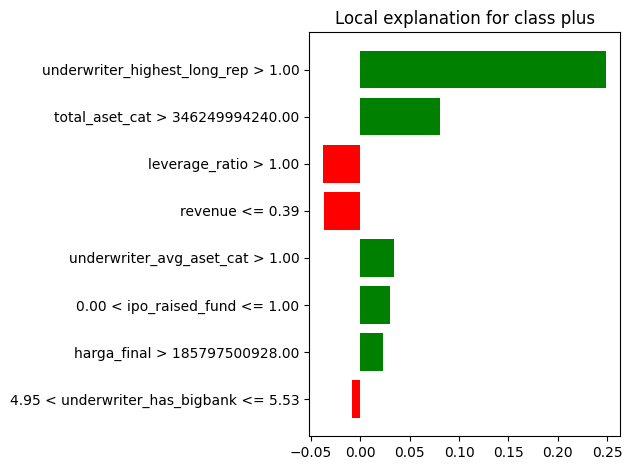

In [1052]:
explain_with_lime(
    model=tabnet_clf,
    X_train=pd.DataFrame(X_train, columns=categorical_cols + numerical_cols),
    X_test=pd.DataFrame(X_test, columns=categorical_cols + numerical_cols),
    feature_names=categorical_cols + numerical_cols,
    class_names=['minus', 'plus']
)

### 1D %

#### TabPFN

In [1054]:
X = df_custom[features_to_use['1d']]
y = df_custom['1d']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)

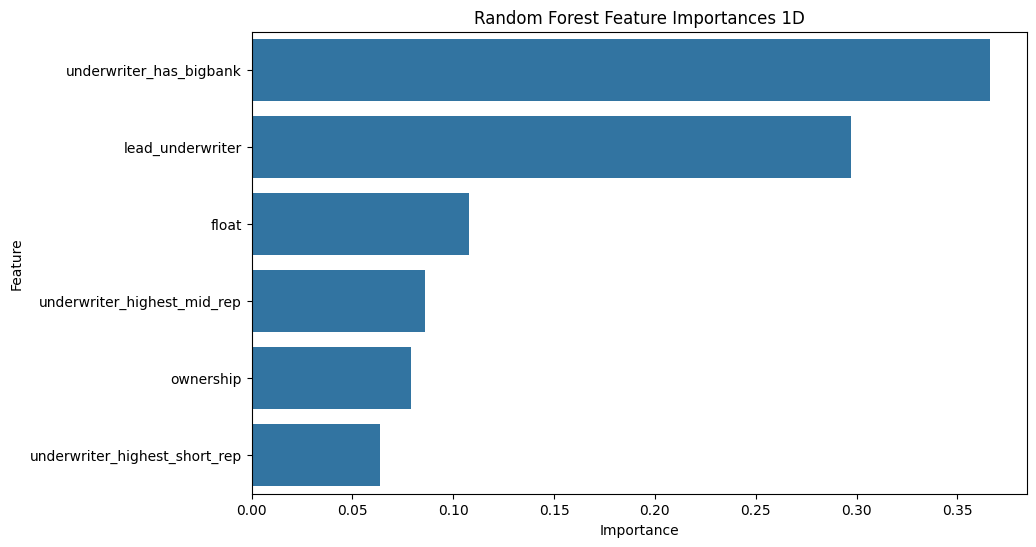

In [1057]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

importances = rf.feature_importances_
importances = pd.Series(importances, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features_to_use['1d'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances 1D")
plt.show()

In [1058]:
clf = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu")

clf.fit(X_train, y_train)

TabPFNClassifier(device='cpu')

In [1059]:
y_pred = clf.predict(X_test)

In [1060]:
thresholds = np.arange(0.3, 0.61, 0.01)
f1_scores = []

probs = cross_val_predict(
    clf,
    X, y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method='predict_proba'
)[:, 1]

for t in thresholds:
    preds = (probs >= t).astype(int)
    score = f1_score(y, preds, average='macro')
    f1_scores.append(score)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Macro Score: {best_f1:.4f}")

Best Threshold: 0.30
Best F1 Macro Score: 0.3679


Classification Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        24
           1       0.80      0.44      0.57         9
           2       0.00      0.00      0.00        12

    accuracy                           0.62        45
   macro avg       0.47      0.48      0.44        45
weighted avg       0.48      0.62      0.51        45



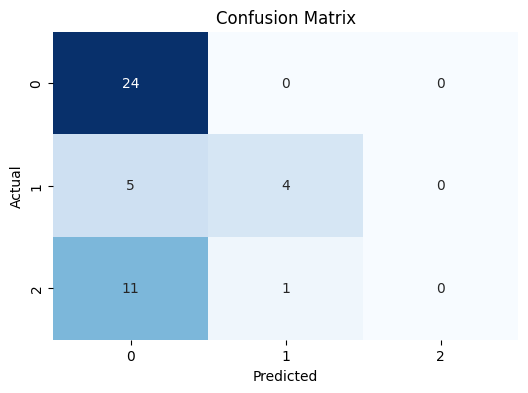

In [1061]:
probs = clf.predict_proba(X_test)[:, 1]
y_pred = (probs > best_threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.53      1.00      0.70        24
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        12

    accuracy                           0.53        45
   macro avg       0.18      0.33      0.23        45
weighted avg       0.28      0.53      0.37        45



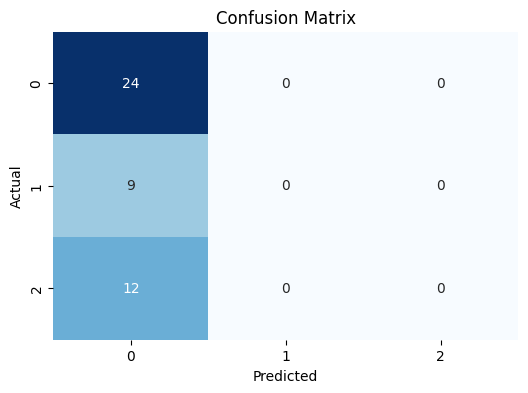

In [1065]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
probs = cross_val_predict(
    clf,
    X, y,
    cv=cv,
    method='predict_proba'
)[:, 1]

probs = clf.predict_proba(X_test)[:, 1]
y_pred = (probs > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [1066]:
import joblib

with open('tabPFN_1D.pkl', 'wb') as f:
    joblib.dump(clf, f)

#### Tabnet

In [1087]:
categorical_cols = []
numerical_cols = []

cols_to_ignore = ['1d', '1w', '1m', '6m', '1y']

for col in features_to_use['1d']:
    if col in cols_to_ignore:
        continue

    if is_categorical(df_custom, col):
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

In [1088]:
df_tabnet = df_custom.copy()

X = df_tabnet[features_to_use['1d']].copy()
y = df_tabnet['1d'].astype(int).values

encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])
X = X.values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [1102]:
from pytorch_tabnet.tab_model import TabNetClassifier
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
import torch

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

class_weights_tensor = torch.FloatTensor(weights)

loss_function = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

In [1105]:
tabnet_clf = TabNetClassifier(
    n_d=16,
    n_a=16,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"mode": "min", "patience": 5, "factor": 0.5},
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    seed=42,
    verbose=1
)

tabnet_clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["val"],
    eval_metric=["balanced_accuracy"],
    max_epochs=200,
    patience=20,
    batch_size=16,
)

epoch 0  | loss: 1.50489 | val_balanced_accuracy: 0.36111 |  0:00:00s
epoch 1  | loss: 1.21472 | val_balanced_accuracy: 0.33333 |  0:00:01s
epoch 2  | loss: 1.14025 | val_balanced_accuracy: 0.33333 |  0:00:01s
epoch 3  | loss: 1.08587 | val_balanced_accuracy: 0.36111 |  0:00:02s
epoch 4  | loss: 0.9401  | val_balanced_accuracy: 0.36111 |  0:00:02s
epoch 5  | loss: 0.9511  | val_balanced_accuracy: 0.33333 |  0:00:03s
epoch 6  | loss: 0.91098 | val_balanced_accuracy: 0.33333 |  0:00:06s
epoch 7  | loss: 0.91001 | val_balanced_accuracy: 0.33333 |  0:00:07s
epoch 8  | loss: 0.90735 | val_balanced_accuracy: 0.33333 |  0:00:08s
epoch 9  | loss: 0.87331 | val_balanced_accuracy: 0.36111 |  0:00:08s
epoch 10 | loss: 0.86287 | val_balanced_accuracy: 0.36111 |  0:00:09s
epoch 11 | loss: 0.88804 | val_balanced_accuracy: 0.33333 |  0:00:09s
epoch 12 | loss: 0.93746 | val_balanced_accuracy: 0.36111 |  0:00:10s
epoch 13 | loss: 0.87133 | val_balanced_accuracy: 0.36111 |  0:00:11s
epoch 14 | loss: 0.8

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.92      0.72        24
           1       0.20      0.11      0.14         9
           2       1.00      0.25      0.40        12

    accuracy                           0.58        45
   macro avg       0.60      0.43      0.42        45
weighted avg       0.62      0.58      0.52        45



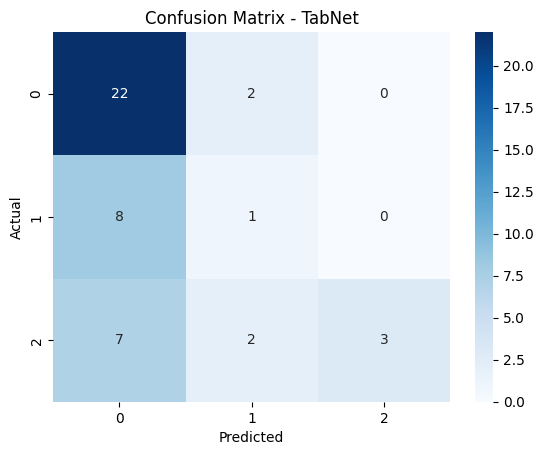

In [1106]:
y_pred = tabnet_clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

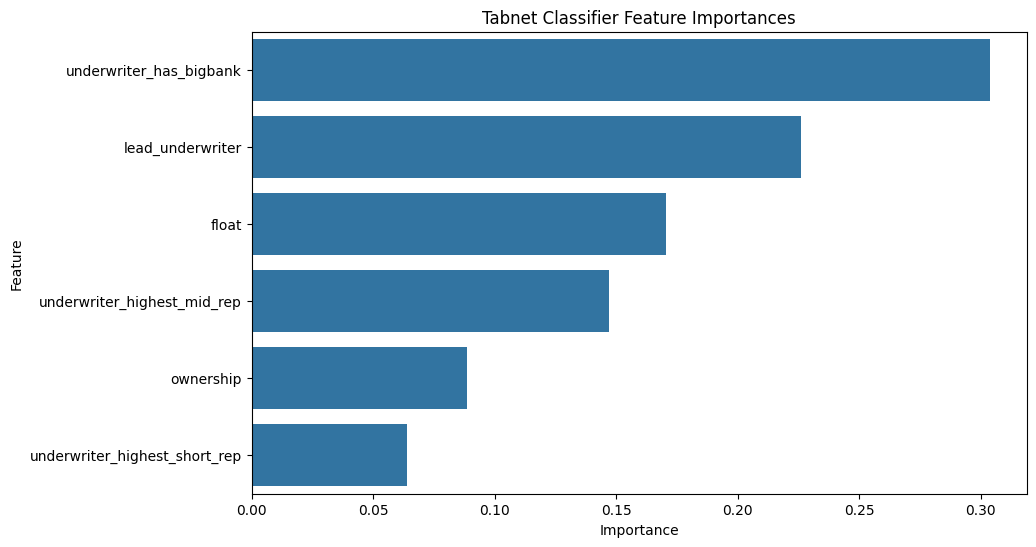

In [1077]:
importances = tabnet_clf.feature_importances_
importances = pd.Series(importances)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features_to_use['1d'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Tabnet Classifier Feature Importances")
plt.show()

In [1078]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

X[:, -len(numerical_cols):] = StandardScaler().fit_transform(X[:, -len(numerical_cols):])

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_preds = []
y_true = []

for train_idx, test_idx in cv.split(X_resampled, y_resampled):
    X_tr, X_te = X_resampled[train_idx], X_resampled[test_idx]
    y_tr, y_te = y_resampled[train_idx], y_resampled[test_idx]

    model = TabNetClassifier(
        seed=42,
        verbose=10,
    )

    model.fit(
        X_train=X_tr, y_train=y_tr,
        eval_set=[(X_te, y_te)],
        eval_name=["val"],
        eval_metric=["balanced_accuracy"],
        batch_size=16,
    )

    y_preds.extend(model.predict(X_te))
    y_true.extend(y_te)

print(classification_report(y_true, y_preds))

epoch 0  | loss: 1.15674 | val_balanced_accuracy: 0.38889 |  0:00:01s
epoch 10 | loss: 0.95607 | val_balanced_accuracy: 0.47645 |  0:00:07s
epoch 20 | loss: 0.91262 | val_balanced_accuracy: 0.54891 |  0:00:14s
epoch 30 | loss: 0.90305 | val_balanced_accuracy: 0.56461 |  0:00:21s

Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_balanced_accuracy = 0.57971
epoch 0  | loss: 1.13768 | val_balanced_accuracy: 0.39372 |  0:00:00s
epoch 10 | loss: 0.93745 | val_balanced_accuracy: 0.44384 |  0:00:06s
epoch 20 | loss: 0.91921 | val_balanced_accuracy: 0.47283 |  0:00:10s
epoch 30 | loss: 0.89226 | val_balanced_accuracy: 0.52838 |  0:00:13s

Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_balanced_accuracy = 0.59964
epoch 0  | loss: 1.22031 | val_balanced_accuracy: 0.39976 |  0:00:00s
epoch 10 | loss: 0.97241 | val_balanced_accuracy: 0.52959 |  0:00:05s

Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_balanced_accuracy = 0.58454
epoc

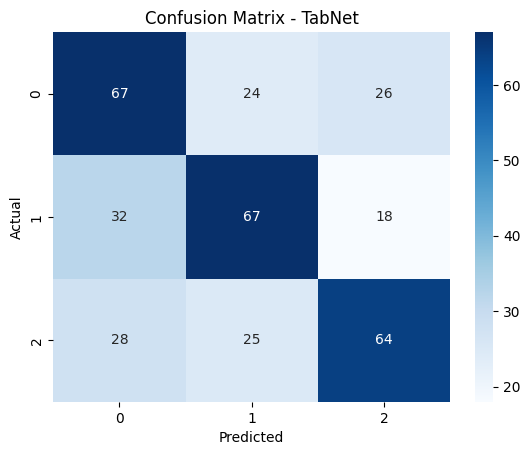

In [1080]:
cm = confusion_matrix(y_true, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

In [ ]:
import joblib

with open('tabnet_1D.pkl', 'wb') as f:
    joblib.dump(tabnet_clf, f)

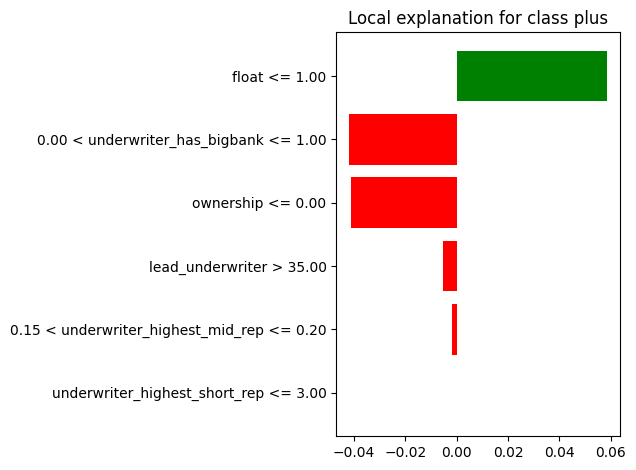

In [1079]:
explain_with_lime(
    model=tabnet_clf,
    X_train=pd.DataFrame(X_train, columns=categorical_cols + numerical_cols),
    X_test=pd.DataFrame(X_test, columns=categorical_cols + numerical_cols),
    feature_names=categorical_cols + numerical_cols,
    class_names=['ARA', 'plus', 'minus']
)

### 1W %

#### TabPFN

In [ ]:
X_raw = df[categorical_cols + numeric_cols].copy()
X_raw[categorical_cols] = OrdinalEncoder().fit_transform(X_raw[categorical_cols])
X_raw = X_raw.astype('float32')

y_raw = df['1W %']
mask = y_raw != 2
X_raw = X_raw[mask]
y_raw = y_raw[mask].astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw)

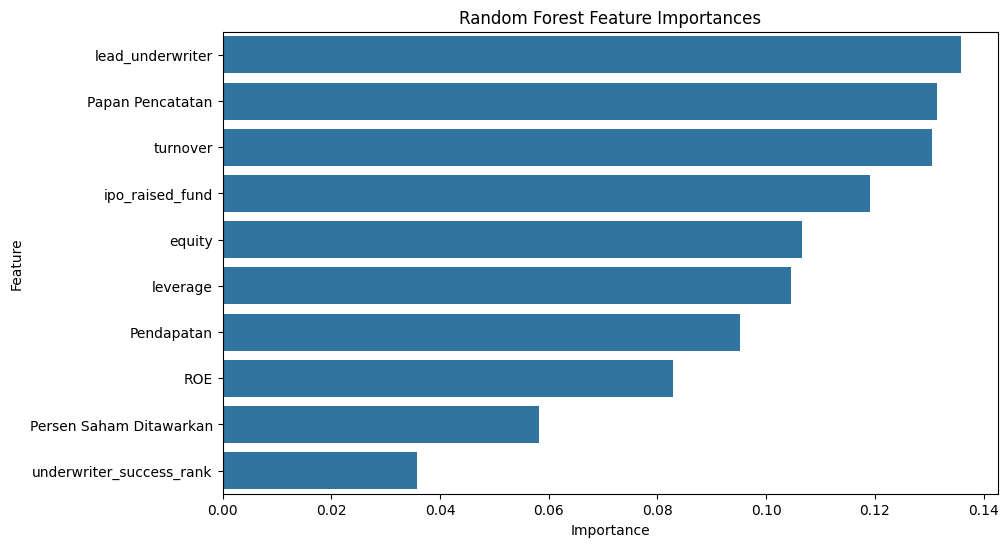

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

importances = rf.feature_importances_
importances = pd.Series(importances, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=categorical_cols + numeric_cols)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.show()

In [ ]:
clf = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu")

clf.fit(X_train, y_train)

TabPFNClassifier(device='cpu')

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
thresholds = np.arange(0.3, 0.61, 0.01)
f1_scores = []

probs = cross_val_predict(
    clf,
    X_raw, y_raw,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method='predict_proba'
)[:, 1]

for t in thresholds:
    preds = (probs >= t).astype(int)
    score = f1_score(y_raw, preds, average='macro')
    f1_scores.append(score)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Macro Score: {best_f1:.4f}")

Best Threshold: 0.59
Best F1 Macro Score: 0.5256


F1 Score (threshold=0.5900000000000003): 0.5256
Accuracy: 0.6098654708520179


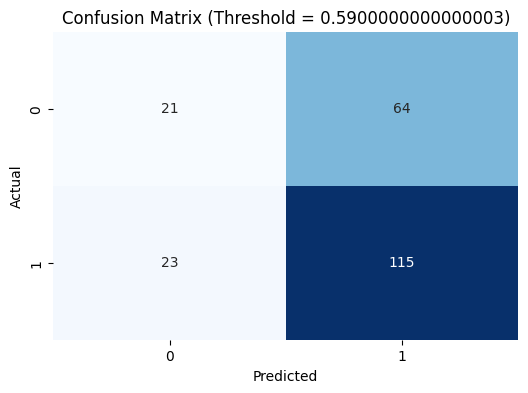

In [ ]:
threshold = best_threshold
preds = (probs >= threshold).astype(int)

cm = confusion_matrix(y_raw, preds)
print(f"F1 Score (threshold={threshold}): {f1_score(y_raw, preds, average='macro'):.4f}")
print(f"Accuracy: {accuracy_score(y_raw, preds)}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

In [ ]:
import joblib

with open('tabPFN_1W.pkl', 'wb') as f:
    joblib.dump(clf, f)

#### Tabnet

In [ ]:
df_tabnet = df[df['1W %'] != 2].copy()

X = df_tabnet[categorical_cols + numeric_cols].copy()
y = df_tabnet['1W %'].astype(int).values

encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])
X = X.values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_clf = TabNetClassifier(
    seed=42,
    verbose=1
)

tabnet_clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["val"],
    eval_metric=["balanced_accuracy"],
    max_epochs=200,
    patience=20,
    batch_size=16
)

epoch 0  | loss: 0.72921 | val_balanced_accuracy: 0.39811 |  0:00:00s
epoch 1  | loss: 0.78868 | val_balanced_accuracy: 0.51576 |  0:00:00s
epoch 2  | loss: 0.72369 | val_balanced_accuracy: 0.49055 |  0:00:01s
epoch 3  | loss: 0.66886 | val_balanced_accuracy: 0.48529 |  0:00:01s
epoch 4  | loss: 0.66219 | val_balanced_accuracy: 0.5     |  0:00:02s
epoch 5  | loss: 0.66921 | val_balanced_accuracy: 0.5     |  0:00:02s
epoch 6  | loss: 0.66305 | val_balanced_accuracy: 0.5     |  0:00:03s
epoch 7  | loss: 0.65835 | val_balanced_accuracy: 0.5     |  0:00:03s
epoch 8  | loss: 0.64824 | val_balanced_accuracy: 0.5     |  0:00:03s
epoch 9  | loss: 0.64442 | val_balanced_accuracy: 0.5     |  0:00:04s
epoch 10 | loss: 0.64206 | val_balanced_accuracy: 0.5     |  0:00:04s
epoch 11 | loss: 0.63252 | val_balanced_accuracy: 0.48214 |  0:00:05s
epoch 12 | loss: 0.65171 | val_balanced_accuracy: 0.5     |  0:00:05s
epoch 13 | loss: 0.66049 | val_balanced_accuracy: 0.5     |  0:00:05s
epoch 14 | loss: 0.6

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.29      0.43        17
           1       0.69      0.96      0.81        28

    accuracy                           0.71        45
   macro avg       0.76      0.63      0.62        45
weighted avg       0.75      0.71      0.67        45



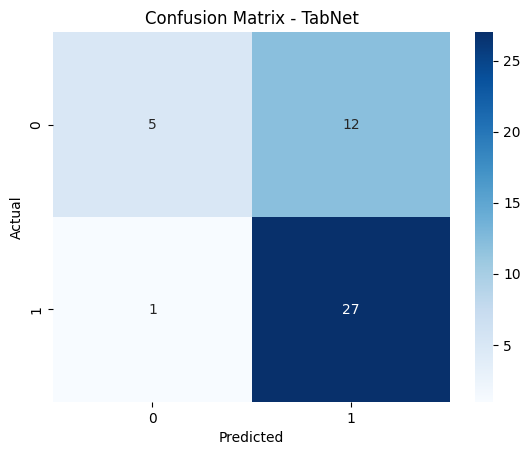

In [ ]:
y_pred = tabnet_clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

X[:, -len(numeric_cols):] = StandardScaler().fit_transform(X[:, -len(numeric_cols):])

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_preds = []
y_true = []

for train_idx, test_idx in cv.split(X_resampled, y_resampled):
    X_tr, X_te = X_resampled[train_idx], X_resampled[test_idx]
    y_tr, y_te = y_resampled[train_idx], y_resampled[test_idx]

    model = TabNetClassifier(
        seed=42,
        verbose=10,
    )

    model.fit(
        X_train=X_tr, y_train=y_tr,
        eval_set=[(X_te, y_te)],
        eval_name=["val"],
        eval_metric=["balanced_accuracy"],
        batch_size=16,
    )

    y_preds.extend(model.predict(X_te))
    y_true.extend(y_te)

print(classification_report(y_true, y_preds))

epoch 0  | loss: 0.80554 | val_balanced_accuracy: 0.5     |  0:00:00s
epoch 10 | loss: 0.67448 | val_balanced_accuracy: 0.625   |  0:00:06s
epoch 20 | loss: 0.66895 | val_balanced_accuracy: 0.57143 |  0:00:17s

Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_balanced_accuracy = 0.625
epoch 0  | loss: 0.79732 | val_balanced_accuracy: 0.43585 |  0:00:00s
epoch 10 | loss: 0.6717  | val_balanced_accuracy: 0.56878 |  0:00:05s
epoch 20 | loss: 0.65561 | val_balanced_accuracy: 0.60185 |  0:00:09s

Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_balanced_accuracy = 0.63757
epoch 0  | loss: 0.78053 | val_balanced_accuracy: 0.39881 |  0:00:00s
epoch 10 | loss: 0.67583 | val_balanced_accuracy: 0.63757 |  0:00:04s
epoch 20 | loss: 0.65813 | val_balanced_accuracy: 0.54365 |  0:00:10s

Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_balanced_accuracy = 0.65807
epoch 0  | loss: 0.75923 | val_balanced_accuracy: 0.4795  |  0:00:00s
epoch

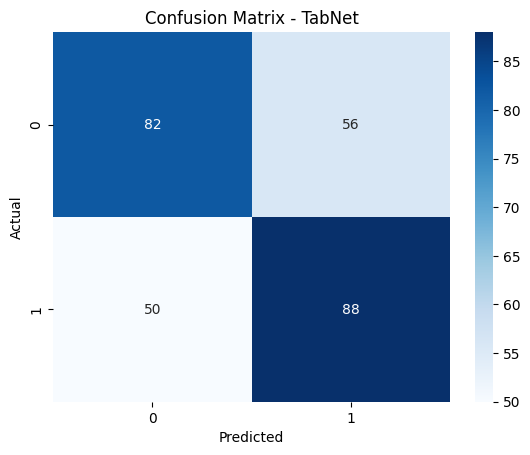

In [ ]:
cm = confusion_matrix(y_true, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

In [ ]:
import joblib

with open('tabnet_1W.pkl', 'wb') as f:
    joblib.dump(tabnet_clf, f)

### 1M %

#### TabPFN

In [ ]:
X_raw = df[categorical_cols + numeric_cols].copy()
X_raw[categorical_cols] = OrdinalEncoder().fit_transform(X_raw[categorical_cols])
X_raw = X_raw.astype('float32')

y_raw = df['1M %']
mask = y_raw != 2
X_raw = X_raw[mask]
y_raw = y_raw[mask].astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw)

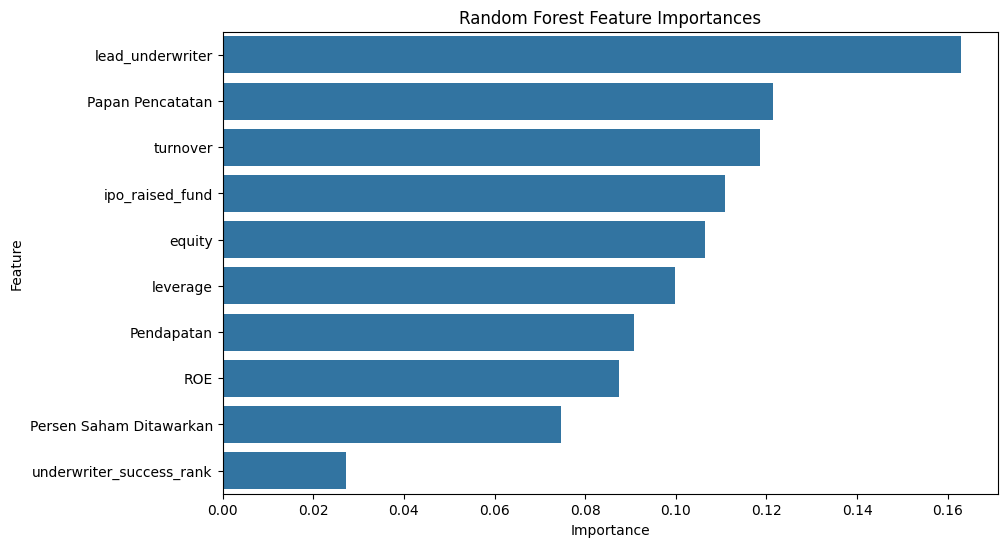

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

importances = rf.feature_importances_
importances = pd.Series(importances, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=categorical_cols + numeric_cols)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.show()

In [ ]:
clf = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu")

clf.fit(X_train, y_train)

TabPFNClassifier(device='cpu')

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
thresholds = np.arange(0.3, 0.61, 0.01)
f1_scores = []

probs = cross_val_predict(
    clf,
    X_raw, y_raw,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method='predict_proba'
)[:, 1]

for t in thresholds:
    preds = (probs >= t).astype(int)
    score = f1_score(y_raw, preds, average='macro')
    f1_scores.append(score)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Macro Score: {best_f1:.4f}")

Best Threshold: 0.53
Best F1 Macro Score: 0.5502


F1 Score (threshold=0.5300000000000002): 0.5502
Accuracy: 0.5520361990950227


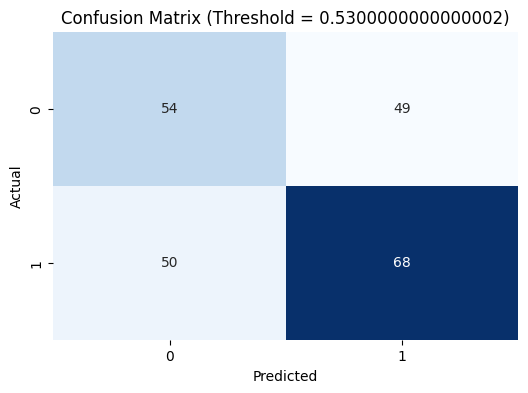

In [ ]:
threshold = best_threshold
preds = (probs >= threshold).astype(int)

cm = confusion_matrix(y_raw, preds)
print(f"F1 Score (threshold={threshold}): {f1_score(y_raw, preds, average='macro'):.4f}")
print(f"Accuracy: {accuracy_score(y_raw, preds)}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

In [ ]:
import joblib

with open('tabPFN_1M.pkl', 'wb') as f:
    joblib.dump(clf, f)

#### Tabnet

In [ ]:
df_tabnet = df[df['1M %'] != 2].copy()

X = df_tabnet[categorical_cols + numeric_cols].copy()
y = df_tabnet['1M %'].astype(int).values

encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])
X = X.values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_clf = TabNetClassifier(
    seed=42,
    verbose=1
)

tabnet_clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["val"],
    eval_metric=["balanced_accuracy"],
    max_epochs=200,
    patience=20,
    batch_size=16
)

epoch 0  | loss: 0.76921 | val_balanced_accuracy: 0.46131 |  0:00:00s
epoch 1  | loss: 0.7622  | val_balanced_accuracy: 0.46726 |  0:00:01s
epoch 2  | loss: 0.76307 | val_balanced_accuracy: 0.54464 |  0:00:01s
epoch 3  | loss: 0.63836 | val_balanced_accuracy: 0.56845 |  0:00:02s
epoch 4  | loss: 0.6796  | val_balanced_accuracy: 0.53571 |  0:00:02s
epoch 5  | loss: 0.66711 | val_balanced_accuracy: 0.49405 |  0:00:03s
epoch 6  | loss: 0.66318 | val_balanced_accuracy: 0.48512 |  0:00:03s
epoch 7  | loss: 0.69925 | val_balanced_accuracy: 0.41964 |  0:00:04s
epoch 8  | loss: 0.67977 | val_balanced_accuracy: 0.47619 |  0:00:04s
epoch 9  | loss: 0.64814 | val_balanced_accuracy: 0.46726 |  0:00:05s
epoch 10 | loss: 0.6814  | val_balanced_accuracy: 0.50595 |  0:00:06s
epoch 11 | loss: 0.62839 | val_balanced_accuracy: 0.4375  |  0:00:07s
epoch 12 | loss: 0.67692 | val_balanced_accuracy: 0.53274 |  0:00:07s
epoch 13 | loss: 0.66519 | val_balanced_accuracy: 0.54167 |  0:00:08s
epoch 14 | loss: 0.6

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.43      0.49        21
           1       0.59      0.71      0.64        24

    accuracy                           0.58        45
   macro avg       0.57      0.57      0.56        45
weighted avg       0.58      0.58      0.57        45



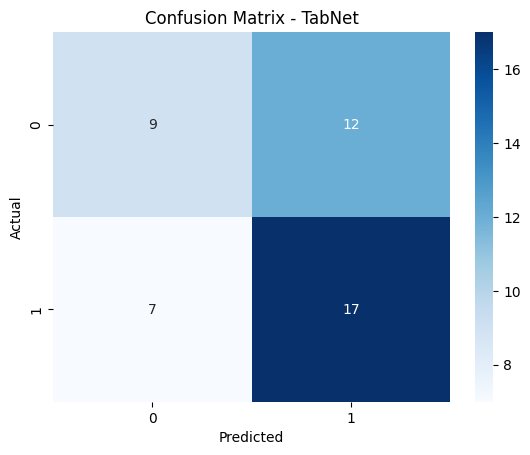

In [ ]:
y_pred = tabnet_clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

X[:, -len(numeric_cols):] = StandardScaler().fit_transform(X[:, -len(numeric_cols):])

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_preds = []
y_true = []

for train_idx, test_idx in cv.split(X_resampled, y_resampled):
    X_tr, X_te = X_resampled[train_idx], X_resampled[test_idx]
    y_tr, y_te = y_resampled[train_idx], y_resampled[test_idx]

    model = TabNetClassifier(
        seed=42,
        verbose=10,
    )

    model.fit(
        X_train=X_tr, y_train=y_tr,
        eval_set=[(X_te, y_te)],
        eval_name=["val"],
        eval_metric=["balanced_accuracy"],
        batch_size=16,
    )

    y_preds.extend(model.predict(X_te))
    y_true.extend(y_te)

print(classification_report(y_true, y_preds))

epoch 0  | loss: 0.8047  | val_balanced_accuracy: 0.625   |  0:00:00s
epoch 10 | loss: 0.68824 | val_balanced_accuracy: 0.625   |  0:00:08s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_balanced_accuracy = 0.66667
epoch 0  | loss: 0.83909 | val_balanced_accuracy: 0.57971 |  0:00:02s
epoch 10 | loss: 0.65997 | val_balanced_accuracy: 0.42754 |  0:00:06s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_balanced_accuracy = 0.63678
epoch 0  | loss: 0.81273 | val_balanced_accuracy: 0.49728 |  0:00:00s
epoch 10 | loss: 0.69698 | val_balanced_accuracy: 0.54801 |  0:00:03s

Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_balanced_accuracy = 0.56884
epoch 0  | loss: 0.77465 | val_balanced_accuracy: 0.53351 |  0:00:00s
epoch 10 | loss: 0.64348 | val_balanced_accuracy: 0.48822 |  0:00:02s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_balanced_accuracy = 0.59873
epoch 0  | loss: 0.77852 | val_balanced_accuracy

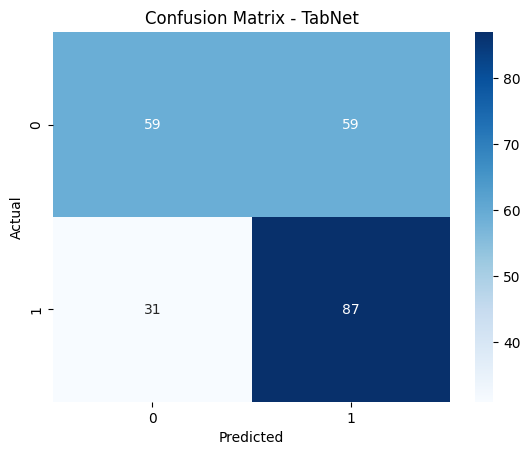

In [ ]:
cm = confusion_matrix(y_true, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

In [ ]:
import joblib

with open('tabnet_1M.pkl', 'wb') as f:
    joblib.dump(tabnet_clf, f)